# Prueba técnica Experto Ciencia de Datos

## Contexto

TIGO es una compañía propiedad del Grupo EPM y Millicom, presente en el mercado B2C y B2B desde 2006 con servicios de telefonía móvil pospago y prepago, y servicios de hogar: internet, televisión y telefonía. Como expert@ de ciencia de datos, serás responsable de guiar técnicamente el equipo encargado de desarrollar modelos y soluciones de análisis de datos para mejorar la experiencia del cliente, reducir el churn y aumentar la eficiencia en los procesos de la empresa.

## Desafio

El primer desafío que enfrentará el Experto de Ciencia de Datos es liderar el desarrollo de un modelo predictivo que permita identificar clientes del producto móvil prepago con mayor probabilidad de abandonar nuestro servicio (hacer churn). Para este propósito, se ha compartido una base de datos en formato parquet con una muestra de clientes prepago, indicando para cada uno si el cliente realizó o no churn durante el mes, acompañado de las variables que describen su comportamiento durante los últimos 4 meses. La predicción se desea hacer sobre aquellos clientes que generen más de $1.500 pesos en su revenue total. Al final se anexa la descripción de las variables.


## Análisis exploratorio de datos

In [102]:
import pandas as pd
import numpy as np
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [103]:
df = pd.read_parquet('df_prueba.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 103 entries, ID to pqt_mas_comprado_M.3
dtypes: float64(40), int64(38), object(25)
memory usage: 392.9+ MB


In [104]:
# Distribución inicial de la variable de Interes
df['TIPO'].value_counts()

TIPO
Base     490841
Churn      9159
Name: count, dtype: int64

In [105]:
# Variable que indica 'Sí el usuario consumió 1500 pesos o más'
df['CORE'].value_counts()

CORE
CORE       267686
NO CORE    232314
Name: count, dtype: int64

In [106]:
# impacto que tiene aplicar el filtro 'CORE'
conting_tbl_core = pd.crosstab(df['CORE'], df['TIPO'])
print(conting_tbl_core)

TIPO       Base  Churn
CORE                  
CORE     264481   3205
NO CORE  226360   5954


El churn queda definido como el 1.2% de la base

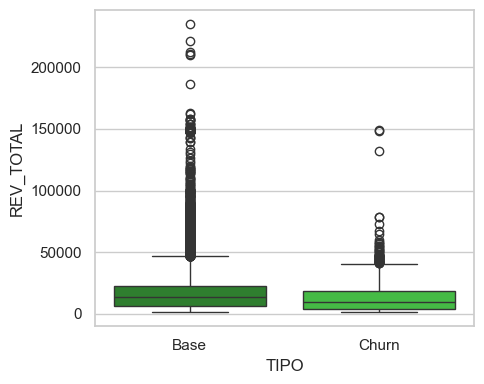

In [ ]:
# Distribucion del REV_TOTAL vs CHURN

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Configurar la figura con dos subgráficos
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
palette_no = {'Base': 'forestgreen', 'Churn': 'limegreen'}

sns.boxplot(x=df['TIPO'], y=df['REV_TOTAL'], hue=df['TIPO'], palette=palette_no, legend=False)

plt.tight_layout()
plt.show()


In [152]:
# aplicamos el filtro

df = df[df['CORE']=='CORE']
df.reset_index(inplace = True, drop = True)
print(df.shape)

df['TIPO'].value_counts()

(267686, 93)


TIPO
Base     264481
Churn      3205
Name: count, dtype: int64

### Tratamiento variable numéricas

In [108]:
# voy a identificar la cantidad de valores nulos en las variables
df_null = df.isnull().sum()
df_null = df_null[df_null > 0]
df_null

ACTIVATION_CHANNEL          21
DIAS_INACTIVIDAD         18316
QTY_PQT                  40697
PQT_MAS_COMPRADO         40697
qty_pqt_M.1              89356
pqt_mas_comprado_M.1     89356
qty_pqt_M.2             103197
pqt_mas_comprado_M.2    103197
qty_pqt_M.3             114729
pqt_mas_comprado_M.3    114729
dtype: int64

In [109]:
# imputaciones
# Hasta el momento solo la variable 'ACTIVATION_CHANNEL' requiere imputacion, que realizaré con la moda de la variable
act_chn_mod = df['ACTIVATION_CHANNEL'].mode()[0]
df['ACTIVATION_CHANNEL'] = df['ACTIVATION_CHANNEL'].fillna(act_chn_mod)

In [110]:
# evaluo el impacto que tiene los valores null de cada una de estas variables
# sobre la variable tipo Churn
print(df[df['PQT_MAS_COMPRADO'].isnull()]['TIPO'].value_counts())
print(df[df['pqt_mas_comprado_M.1'].isnull()]['TIPO'].value_counts())
print(df[df['pqt_mas_comprado_M.2'].isnull()]['TIPO'].value_counts())
print(df[df['pqt_mas_comprado_M.3'].isnull()]['TIPO'].value_counts())

TIPO
Base     37492
Churn     3205
Name: count, dtype: int64
TIPO
Base     86151
Churn     3205
Name: count, dtype: int64
TIPO
Base     99992
Churn     3205
Name: count, dtype: int64
TIPO
Base     111524
Churn      3205
Name: count, dtype: int64


In [111]:
# evidencio que ninguna de las ateriores variables me ayuda a discriminar el churn
# por este motivo voy a descartarlas
columnas_o_null = ['PQT_MAS_COMPRADO','pqt_mas_comprado_M.1','pqt_mas_comprado_M.2','pqt_mas_comprado_M.3']
df = df.drop(columns = columnas_o_null, axis = 1)

In [112]:
# Variables numéricas que contienen valores nulos
df_null = df.isnull().sum()
df_null = df_null[df_null > 0]
df_null

DIAS_INACTIVIDAD     18316
QTY_PQT              40697
qty_pqt_M.1          89356
qty_pqt_M.2         103197
qty_pqt_M.3         114729
dtype: int64

In [113]:
# voy a revisar la distribución de las varibles que continen valores null
columns_null = df_null.keys()
df_null.values

for c in range(len(columns_null)):
    print('\n')
    des      = df[columns_null[c]].describe()
    #count_n  = des[0:1]['count']
    print(des)



count    249370.000000
mean          4.160897
std          24.014512
min          -1.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        2680.000000
Name: DIAS_INACTIVIDAD, dtype: float64


count    226989.000000
mean          2.732661
std           1.928715
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          41.000000
Name: QTY_PQT, dtype: float64


count    178330.000000
mean          2.964902
std           1.922853
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max          44.000000
Name: qty_pqt_M.1, dtype: float64


count    164489.000000
mean          3.024834
std           1.964753
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max          42.000000
Name: qty_pqt_M.2, dtype: float64


count    152957.000000
mean          2.968194
std           1.895368
min           1.000000
25%           1.000000
50

In [114]:
cols_null_l = columns_null.tolist()
print(cols_null_l)

for c in range(len(cols_null_l)):
    print(cols_null_l[c], '\n')
    print('Churn \n',df[df['TIPO']=='Churn'][cols_null_l[c]].describe())
    print('Base \n',df[df['TIPO']=='Base'][cols_null_l[c]].describe())
    

['DIAS_INACTIVIDAD', 'QTY_PQT', 'qty_pqt_M.1', 'qty_pqt_M.2', 'qty_pqt_M.3']
DIAS_INACTIVIDAD 

Churn 
 count    3205.000000
mean        2.175351
std         4.934257
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        29.000000
Name: DIAS_INACTIVIDAD, dtype: float64
Base 
 count    246165.000000
mean          4.186749
std          24.162706
min          -1.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        2680.000000
Name: DIAS_INACTIVIDAD, dtype: float64
QTY_PQT 

Churn 
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: QTY_PQT, dtype: float64
Base 
 count    226989.000000
mean          2.732661
std           1.928715
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          41.000000
Name: QTY_PQT, dtype: float64
qty_pqt_M.1 

Churn 
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN

In [115]:
# imputar con la media
dias_inac_pro = df['DIAS_INACTIVIDAD'].mean()
df['DIAS_INACTIVIDAD'] = df['DIAS_INACTIVIDAD'].fillna(round(dias_inac_pro, 2))

In [116]:
# dado el número de outliers voy a 
# imputar con la mediana
list_median = ['QTY_PQT', 'qty_pqt_M.1', 'qty_pqt_M.2', 'qty_pqt_M.3']
for c in range(len(list_median)):
    c_median = df[list_median[c]].median()
    df[list_median[c]] = df[list_median[c]].fillna(round(c_median, 2))

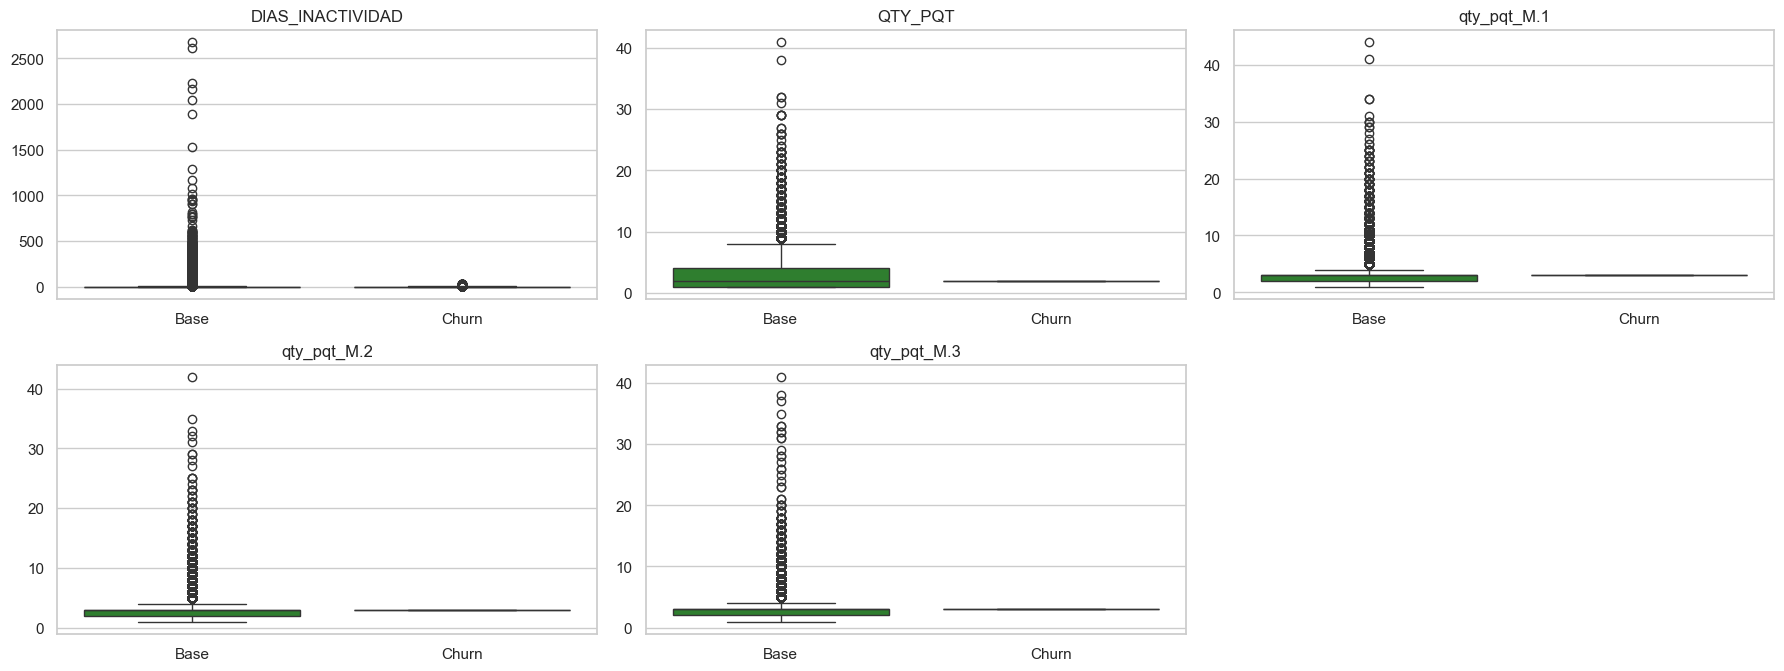

In [117]:
# presento una grilla con diagramas de bigote para analizar la distribución
# de las variables procesadas y su relación con el churn

%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


num_vars = len(cols_null_l)  # Número de variables

# Configurar la figura y ejes
fig, axes = plt.subplots(6, 3, figsize=(18, 20))  # Grilla de 6x3
palette_no = {'Base': 'forestgreen', 'Churn': 'limegreen'}

# Generar gráficos en cada celda
for i, ax in enumerate(axes.flat[:num_vars]):
    sns.boxplot(x=df['TIPO']
                , y=df[cols_null_l[i]]
                , data=df
                , hue=df['TIPO']
                , palette=palette_no
                , legend=False
                , ax = ax
               )
    ax.set_title(cols_null_l[i])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Ocultar las celdas vacías
for j in range(num_vars, len(axes.flat)):
    axes.flat[j].set_visible(False)

# Ajustar el diseño
plt.tight_layout()
plt.show()



In [118]:
# despues de revisar los resultados del anterior ejercicio 
# encuentro que los valores asociados al churn de estas variables es constante
# y cada variable tiene un valor importante de nulos,
# por este motivo voy a retirarlas del análisis, con excepcion de 'DIAS_INACTIVIDAD'

cols_null_l.remove('DIAS_INACTIVIDAD')
cols_null_l
df = df.drop(cols_null_l, axis = 1)

### Tratamiento variable categóricas

In [119]:
# descartamos las columnas con valores constantes, en este caso 'MOBILE' para la columna BUSINESS_UNIT
df = df.drop('BUSINESS_UNIT', axis = 1)
df = df.drop('ARPU', axis = 1)

In [120]:
# creo una lista con las variables tipo Objeto
columns_ob = df.select_dtypes(include=['object']).columns
columns_ob = columns_ob.tolist()

In [121]:
# creo una lista con las variables numéricas
columns_df = df.columns
columns_num = [c for c in columns_df if c not in columns_ob]

In [123]:
df[columns_ob].describe()

,TIPO,RAZON,ACTIVATION_CHANNEL,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,CITY,OPENING,GROSS,RECONNECTION,CORE,CORE_M-1,CORE_M-2,CORE_M-3
count,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686,267686
unique,2,2,13,3,3,2,2,2,2,5,5,34,701,2,2,2,1,2,2,2
top,Base,Base,DISTRIBUIDORES,4G,2G,Y,Y,Y,Y,SMARTPHONE,COSTA,ANTIOQUIA,MEDELLÍN,Y,N,N,CORE,CORE,CORE,CORE
freq,264481,264481,186363,224396,144554,238771,185599,171150,155839,245221,107529,58312,31879,237275,239268,265693,267686,205129,189814,176892


### Distribución de variables categóricas

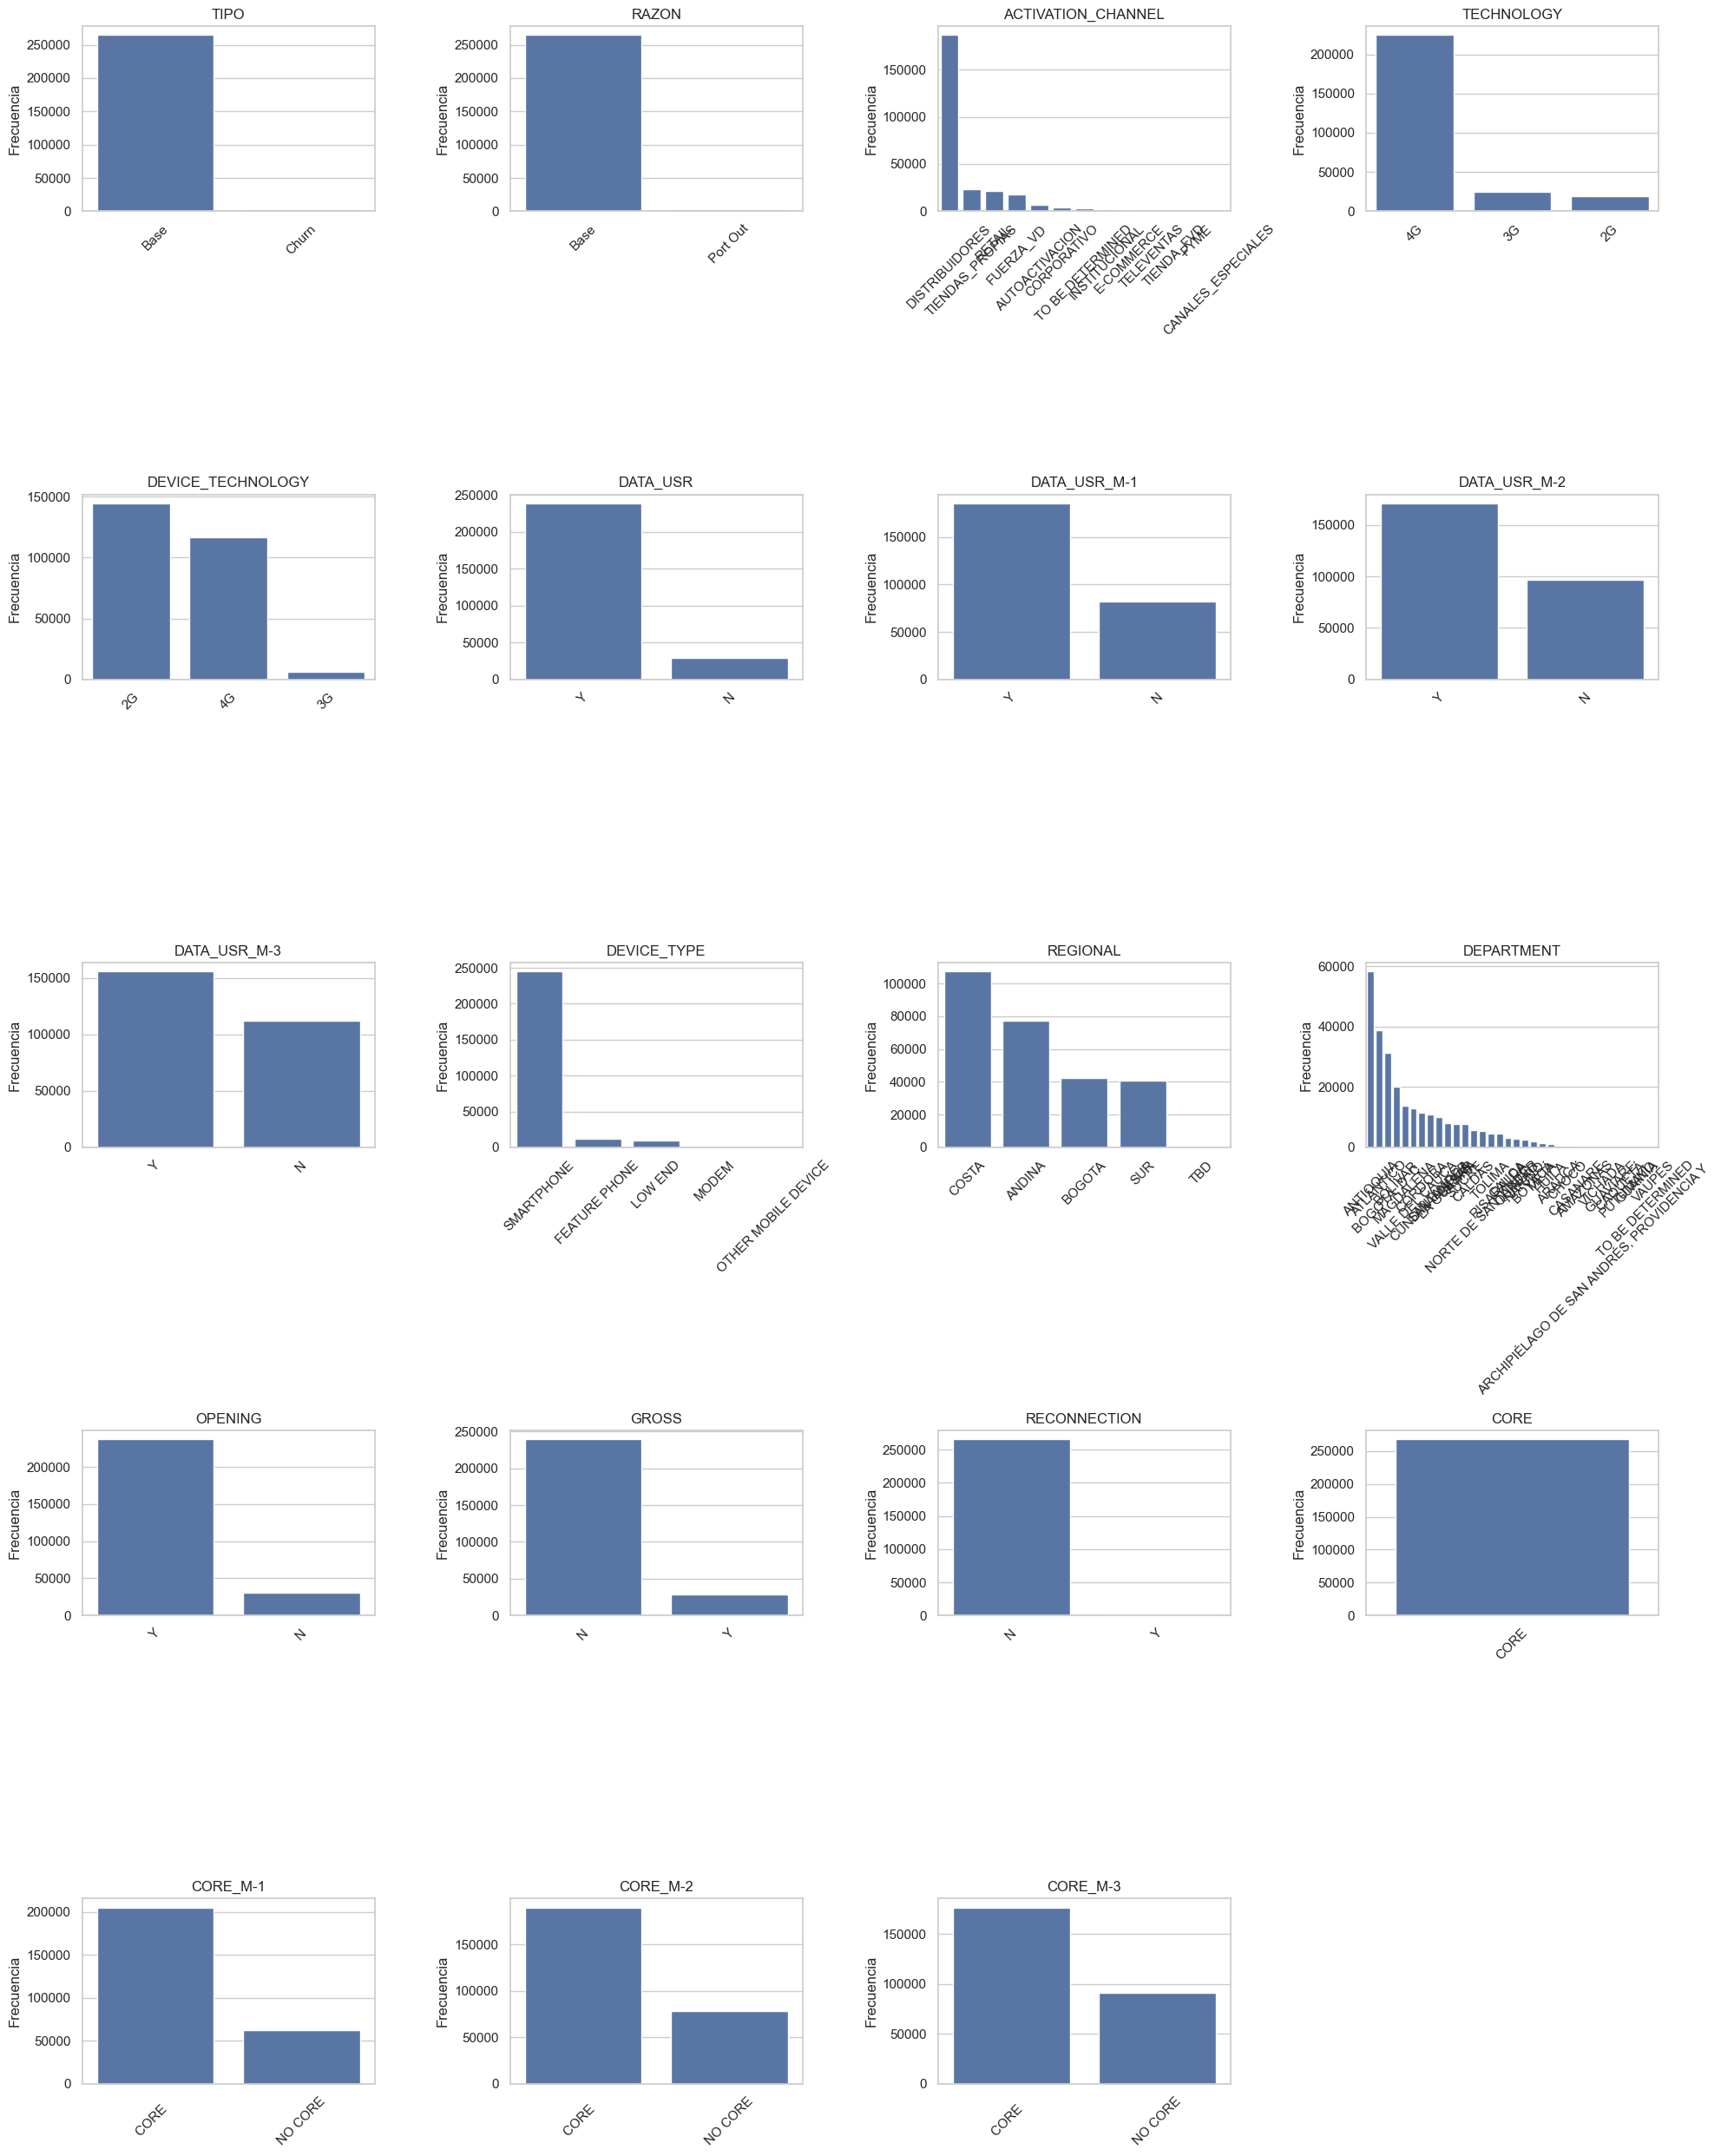

In [ ]:
# Distribución de variables categóricas de interes

columns_obg = columns_ob
columns_obg.remove('CITY')
num_vars = len(columns_ob)

# Configurar la figura y ejes
fig, axes = plt.subplots(5, 4, figsize=(20, 25))  # Grilla de 5x4 para 20 variables

# Generar histogramas en cada celda
for i, ax in enumerate(axes.flat[:num_vars]):
    # Ordenar categorías por frecuencia descendente
    sorted_order = df[columns_obg[i]].value_counts().index

    sns.countplot(x=df[columns_obg[i]]
                  ,data=df
                  ,legend=False
                  ,order=sorted_order  # Ordenar categorías de mayor a menor
                  ,ax=ax)

    ax.set_title(columns_obg[i])  # Título con el nombre de la variable
    ax.set_xlabel('')  # Ocultar etiquetas del eje X
    ax.set_ylabel('Frecuencia')  # Etiqueta del eje Y
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas para mejor visualización

# Ocultar celdas vacías si hay menos de 20 variables
for j in range(num_vars, len(axes.flat)):
    axes.flat[j].set_visible(False)

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [22]:
# Despues de revisar el comportamiento de estas variables categoricas las retiro
# por su cardinalidad y valores frecuentes 

# Definición de variable categoricas a retirar
columns_o_ret = ['RAZON','OPENING','DEVICE_TECHNOLOGY','CORE_M-1','CORE_M-2','CORE_M-3','RECONNECTION','DEPARTMENT','CITY']
df = df.drop(columns = columns_o_ret)

#variables a retirar 2
columns_o_ret2 = ['PCKG_VOICE_FIXNET_M-1','PCKG_VOICE_FIXNET_M-2','PCKG_VOICE_FIXNET_M-3','CORE']
df = df.drop(columns = columns_o_ret2)

In [23]:
# refresco el listado columns_ob
columns_ob = df.select_dtypes(include=['object']).columns
columns_ob = columns_ob.tolist()

In [26]:
# Recategorizacion 
# voy a recategorizar los registros de las variables categoricas definidas

df['ACTIVATION_CHANNEL'] = df['ACTIVATION_CHANNEL'].apply(lambda x : 'OTHERS' if x != 'DISTRIBUIDORES' else x)
df['TECHNOLOGY']         = df['TECHNOLOGY'].apply(lambda x : '3G Y 4G' if x != '2G' else x)
df['DEVICE_TYPE']        = df['DEVICE_TYPE'].apply(lambda x : 'LOW END AND OTHER MOB DEV' if x != 'SMARTPHONE' else x)

In [27]:
# Codigo para perfilar los datos con Pandas - Profiling
"""from ydata_profiling import ProfileReport

profile = ProfileReport(df[columns_ob], title="Análisis Inicial Exploratorios de Datos")
profile.to_notebook_iframe()
profile.to_file("eda_ini_f.html")"""

'from ydata_profiling import ProfileReport\n\nprofile = ProfileReport(df[columns_ob], title="Análisis Inicial Exploratorios de Datos")\nprofile.to_notebook_iframe()\nprofile.to_file("eda_ini_f.html")'

In [28]:
# Medir impacto en el churn de variables categoricas correlacionadas
conting_tbl_du = pd.crosstab(df['DATA_USR'], df['TIPO'])
conting_tbl_dum_1 = pd.crosstab(df['DATA_USR_M-1'], df['TIPO'])
conting_tbl_dum_2 = pd.crosstab(df['DATA_USR_M-2'], df['TIPO'])
conting_tbl_dum_3 = pd.crosstab(df['DATA_USR_M-3'], df['TIPO'])

In [29]:
print(conting_tbl_du,'\n')
print(conting_tbl_dum_1,'\n')
print(conting_tbl_dum_2,'\n')
print(conting_tbl_dum_3,'\n')

TIPO        Base  Churn
DATA_USR               
N          28697    218
Y         235784   2987 

TIPO            Base  Churn
DATA_USR_M-1               
N              80554   1533
Y             183927   1672 

TIPO            Base  Churn
DATA_USR_M-2               
N              94738   1798
Y             169743   1407 

TIPO            Base  Churn
DATA_USR_M-3               
N             109905   1942
Y             154576   1263 



In [30]:
# creo una variable que resume sí el usuario Pagó por los datos consumidos en el último Q
df['DATA_USR_Q'] = df.apply(lambda x : 'Y' if ((x['DATA_USR_M-1'] == 'Y') | (x['DATA_USR_M-2'] == 'Y') | (x['DATA_USR_M-3'] == 'Y') ) else 'N', axis = 1)

# retiro las columnas de DATOS del Q
cols_o_cr = ['DATA_USR_M-1','DATA_USR_M-2','DATA_USR_M-3']
df = df.drop(cols_o_cr, axis = 1)

# presento una tabla de contingencia con la variable creada
conting_tbl_duq = pd.crosstab(df['DATA_USR_Q'], df['TIPO'])
conting_tbl_duq

TIPO,Base,Churn
DATA_USR_Q,,
N,56347,1376
Y,208134,1829


In [31]:
# refresco el objeto columns_ob
columns_ob = df.select_dtypes(include=['object']).columns
columns_ob = columns_ob.tolist()

In [32]:
# Refresco el contenido de la lista de variables numericas
columns_df = df.columns
columns_num = [c for c in columns_df if c not in columns_ob]
columns_num.remove('ID')

## Detección de registros anómalos

In [33]:
# Voy a trabajar con las variables numéricas, ejecutare un algoritmo para detectar registros anómalos 
# y compararlos vs la variable TIPO 

# Ejecucion de un algoritmo para detección de datos anómalos
# voy a identificar 1 % de contaminacion esto basado en el conjunto nro 1 de variables numéricas

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

dfn_0 = df[columns_num]
print('df entrada', dfn_0.shape)

# Escalamos los datos (muy importante para algoritmos basados en distancia)
scaler_0 = StandardScaler()

X_scaled_0 = scaler_0.fit_transform(dfn_0)

# Modelo Isolation Forest
contamination_p = 0.01
iso_0 = IsolationForest(n_estimators=100, contamination=contamination_p , random_state=42, n_jobs=-1)

# Entrenar modelo
iso_0.fit(X_scaled_0)

# Predecir: -1 = outlier, 1 = normal
reg_anomalo_0 = iso_0.predict(X_scaled_0)
regs_anomalo_0 = pd.Series(reg_anomalo_0)

dfa = pd.concat([df, regs_anomalo_0.rename('anomaly_0')], axis=1)
print('df anomalos salida ',dfa.shape)

# de los valores clasificados con anomalos voy a validar que 
# impacto tienen en churn
contingency_table_anom_0 = pd.crosstab(dfa['anomaly_0'], dfa['TIPO'])
print(contingency_table_anom_0)

df entrada (267686, 69)
df anomalos salida  (267686, 79)
TIPO         Base  Churn
anomaly_0               
-1           2652     25
 1         261829   3180


In [34]:
# filtro solo los valores anomaly_0 = 1
dfa = dfa[dfa['anomaly_0']==1]
dfa.reset_index(inplace = True, drop = True)
dfa = dfa.drop('anomaly_0', axis = 1)

### Tratamiento de variables numéricas 2

In [35]:
# voy a unificar las variables de los últimos tres meses en Q
# voy a crear sets de datos numericos para validar su distribución

# 'AGEING',
var_num_0 = [
    'QTY_RCHG','AMNT_RCHG','REV_TOTAL','REV_IN','REV_OUT','CALLS_IN','MINUTES_IN','MSG_IN','CALLS_OUT','MINUTES_OUT','MSG_OUT','REV_OUT_COMMUNICATION','REV_OUT_ENTERTAIMENT','REV_OUT_INFORMATION','REV_OUT_SOLUTIONS','CONSUMO_DATOS','DIAS_INACTIVIDAD']

var_num_g =  [
    'QTY_RCHG_M-1','QTY_RCHG_M-2','QTY_RCHG_M-3',

    'AMNT_RCHG_M-1','AMNT_RCHG_M-2','AMNT_RCHG_M-3',

    'REV_TOTAL_M-1','REV_TOTAL_M-2','REV_TOTAL_M-3',

    'REV_IN_M-1','REV_IN_M-2','REV_IN_M-3',

    'REV_OUT_M-1','REV_OUT_M-2','REV_OUT_M-3',

    'CALLS_IN_M-1','CALLS_IN_M-2','CALLS_IN_M-3',

    'MINUTES_IN_M-1','MINUTES_IN_M-2','MINUTES_IN_M-3',

    'MSG_IN_M-1','MSG_IN_M-2','MSG_IN_M-3',

    'CALLS_OUT_M-1','CALLS_OUT_M-2','CALLS_OUT_M-3',

    'MINUTES_OUT_M-1','MINUTES_OUT_M-2','MINUTES_OUT_M-3',

    'MSG_OUT_M-1','MSG_OUT_M-2','MSG_OUT_M-3',

    'REV_OUT_COMMUNICATION_M-1','REV_OUT_COMMUNICATION_M-2','REV_OUT_COMMUNICATION_M-3',

    'REV_OUT_ENTERTAIMENT_M-1','REV_OUT_ENTERTAIMENT_M-2','REV_OUT_ENTERTAIMENT_M-3',

    'REV_OUT_INFORMATION_M-1','REV_OUT_INFORMATION_M-2','REV_OUT_INFORMATION_M-3',

    'REV_OUT_SOLUTIONS_M-1','REV_OUT_SOLUTIONS_M-2','REV_OUT_SOLUTIONS_M-3',

    'CONSUMO_DATOS_M-1','CONSUMO_DATOS_M-2','CONSUMO_DATOS_M-3',

    'DIAS_INACTIVIDAD_M-1','DIAS_INACTIVIDAD_M-2','DIAS_INACTIVIDAD_M-3'
    ]


In [36]:
# defino grupos de columnas para cada mes del Q, porque más adelante voy a crear variables numéricas que resumen
# el comportamiento del Q. De esta menera controlo la correlación que pueda existir entre cada una de las variables
 
var_num_1 = [col for col in var_num_g if '-1' in col]
var_num_2 = [col for col in var_num_g if '-2' in col]
var_num_3 = [col for col in var_num_g if '-3' in col]

#var_num_1.append('qty_pqt_M.1')
#var_num_2.append('qty_pqt_M.2')
#var_num_3.append('qty_pqt_M.3')

In [37]:
# ahora voy a definir valores MIN, MAX y PROMEDIO para las var de último Q
# porque están correlacionadas

# la lista 'var_num_0' contiene el prefijo de los nombres de las columnas que almacenaran los cálculos
for n in range(len(var_num_0)):
    dfa[f'{var_num_0[n]}_Q_min']  = round(dfa[[var_num_1[n], var_num_2[n], var_num_3[n]]].min(axis=1), 2)
    dfa[f'{var_num_0[n]}_Q_max']  = round(dfa[[var_num_1[n], var_num_2[n], var_num_3[n]]].max(axis=1), 2)
    dfa[f'{var_num_0[n]}_Q_mean'] = round(dfa[[var_num_1[n], var_num_2[n], var_num_3[n]]].mean(axis=1), 2)

In [38]:
# mis variables numericas ahora van a ser las contenidas en 'var_num_0'
# y las resultantes de los calculos '_Q_min' , '_Q_max', y '_Q_mean'
# mas 'AGEING' 
dfa_cols = dfa.columns.tolist()
var_num_min  = [c for c in dfa_cols if '_min'  in c]
var_num_max  = [c for c in dfa_cols if '_max'  in c]
var_num_mean = [c for c in dfa_cols if '_mean' in c]

columns_num_2 = ['AGEING']
columns_num_2 = columns_num_2 + var_num_0 + var_num_min + var_num_max + var_num_mean

### Imputacion de variables numéricas

In [39]:
# Voy a aplicar la técnica de recorte de valores extremos superiores e inferiores a 3 veces el IQR
# en las variables numéricas, para estabilizar su comportamiento

dfan_imp = dfa[columns_num_2].copy()

b = 3.0  #1.5 # 3.0
for c in range(len(columns_num_2)):
    col = columns_num_2[c]
    Q1 = dfan_imp[col].quantile(0.25)
    Q3 = dfan_imp[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - b * IQR
    lim_sup = Q3 + b * IQR
    # Ajustar valores fuera del rango directamente
    dfan_imp[f'{col}_imp'] = dfan_imp[col].astype(float)
    dfan_imp.loc[dfan_imp[col] < lim_inf, f'{col}_imp'] = float(lim_inf)  # Limitar valores inferiores
    dfan_imp.loc[dfan_imp[col] > lim_sup, f'{col}_imp'] = float(lim_sup)  # Limitar valores superiores


dfa = pd.concat([dfa,dfan_imp], axis = 1)
del dfan_imp

In [40]:
# Vamos a seleccionar las columas imputadas para hacer el analisis de correlacion 
columns_imp = dfa[[col for col in dfa.columns if '_imp' in col]].columns
columns_imp = columns_imp.tolist()

In [41]:
#voy a retirar las variables numericas que identifico en cero
column_num_poca_varianza = \
['REV_OUT_ENTERTAIMENT_imp'
,'REV_OUT_ENTERTAIMENT_Q_min_imp'
,'REV_OUT_ENTERTAIMENT_Q_max_imp'
,'REV_OUT_ENTERTAIMENT_Q_mean_imp'
,'REV_OUT_SOLUTIONS_imp'
,'REV_OUT_SOLUTIONS_Q_min_imp'
,'REV_OUT_SOLUTIONS_Q_max_imp'
,'REV_OUT_SOLUTIONS_Q_mean_imp'
,'DIAS_INACTIVIDAD_Q_min_imp'
]

# refresco el listado de variable Numéricas
columns_imp = [c for c in columns_imp if c not in column_num_poca_varianza]

In [42]:
# con esta seccion de código completo las columas categoricas y las imputadas

columns_obta = dfa.select_dtypes(include=['object']).columns
columns_obta = columns_obta.tolist()
columns_obta = ['ID'] + columns_obta
columns_t_imp = columns_obta + columns_imp

dfat = dfa[columns_t_imp]
#dfat.shape

In [43]:
# Procedo a realizar un análisis de correlación con las variables numericas
dfani = dfa[columns_imp]

correlation_matrix = dfani.corr(method='pearson')
umbral_factor_corr = 0.8
#print(correlation_matrix)

# Obtener las correlaciones altas (excluyendo correlación consigo misma)
high_corr_pairs = correlation_matrix.unstack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']) & 
    (high_corr_pairs['Correlation'].abs() > umbral_factor_corr)
]
#print(high_corr_pairs)

high_corr_pairs.sort_values('Correlation', ascending = False).head(5)

,Variable 1,Variable 2,Correlation
2986,REV_OUT_Q_mean_imp,AMNT_RCHG_Q_mean_imp,0.991006
2809,AMNT_RCHG_Q_mean_imp,REV_OUT_Q_mean_imp,0.991006
1217,REV_OUT_Q_min_imp,AMNT_RCHG_Q_min_imp,0.987652
1040,AMNT_RCHG_Q_min_imp,REV_OUT_Q_min_imp,0.987652
3584,DIAS_INACTIVIDAD_Q_mean_imp,DIAS_INACTIVIDAD_Q_max_imp,0.987242


In [44]:
# creo este código para validar la interacción de cada una de las variables y su correlación
# en este caso las que superan el umbral del 80%

print(high_corr_pairs.shape,'\n')

high_corr_pairs[high_corr_pairs['Variable 1']=='MSG_OUT_Q_mean_imp'].sort_values('Correlation', ascending = False).head(10)

(236, 3) 



,Variable 1,Variable 2,Correlation
3340,MSG_OUT_Q_mean_imp,MSG_OUT_Q_max_imp,0.959065
3326,MSG_OUT_Q_mean_imp,MSG_OUT_Q_min_imp,0.866890


In [45]:
# en cada iteracion iré agregando variables para excluir del análisis

# correlacionadas sobre 0.8 con 
# MINUTES_OUT_Q_min_imp
crr_MINUTES_OUT_Q_min_imp = ['MINUTES_OUT_Q_mean_imp','AMNT_RCHG_Q_max_imp','CONSUMO_DATOS_Q_mean_imp'
                             ,'MSG_OUT_Q_mean_imp'
                             ,'REV_OUT_COMMUNICATION_Q_mean_imp','REV_IN_Q_mean_imp','REV_OUT_COMMUNICATION_imp'
                             ,'CALLS_OUT_Q_mean_imp','CALLS_OUT_imp'
                             ,'MSG_IN_Q_mean_imp']
columns_imp = [c for c in columns_imp if c not in crr_MINUTES_OUT_Q_min_imp]

# correlacionadas sobre 0.9 con 
# AMNT_RCHG_imp
crr_AMNT_RCHG_imp = ['REV_TOTAL_imp','REV_OUT_imp','REV_OUT_INFORMATION_imp']
columns_imp = [c for c in columns_imp if c not in crr_AMNT_RCHG_imp]

# AMNT_RCHG_Q_max_imp
crr_AMNT_RCHG_Q_max_imp = ['REV_OUT_Q_max_imp','REV_OUT_INFORMATION_Q_max_imp','REV_TOTAL_Q_max_imp','AMNT_RCHG_Q_mean_imp','REV_OUT_Q_mean_imp']
columns_imp = [c for c in columns_imp if c not in crr_AMNT_RCHG_Q_max_imp]

# AMNT_RCHG_Q_min_imp
crr_AMNT_RCHG_Q_min_imp = ['REV_OUT_Q_min_imp','REV_OUT_INFORMATION_Q_min_imp','REV_TOTAL_Q_min_imp','REV_OUT_COMMUNICATION_Q_min_imp']
columns_imp = [c for c in columns_imp if c not in crr_AMNT_RCHG_Q_min_imp]

# CALLS_IN_Q_mean_imp
crr_CALLS_IN_Q_mean_imp = ['CALLS_IN_Q_max_imp','CALLS_IN_Q_min_imp']
columns_imp = [c for c in columns_imp if c not in crr_CALLS_IN_Q_mean_imp]

# CALLS_OUT_Q_mean_imp
crr_CALLS_OUT_Q_mean_imp = ['CALLS_OUT_Q_max_imp','CALLS_OUT_Q_min_imp']
columns_imp = [c for c in columns_imp if c not in crr_CALLS_OUT_Q_mean_imp]


# CONSUMO_DATOS_Q_mean_imp
crr_CONSUMO_DATOS_Q_mean_imp = ['CONSUMO_DATOS_Q_max_imp']
columns_imp = [c for c in columns_imp if c not in crr_CONSUMO_DATOS_Q_mean_imp]

# 
crr_min_max = ['DIAS_INACTIVIDAD_Q_max_imp','MINUTES_IN_Q_max_imp','MINUTES_IN_Q_min_imp','MINUTES_OUT_Q_max_imp'
               ,'MSG_IN_Q_max_imp','MSG_OUT_Q_max_imp','QTY_RCHG_Q_max_imp','QTY_RCHG_Q_min_imp','REV_IN_Q_max_imp'
               ,'REV_IN_Q_min_imp','REV_OUT_INFORMATION_Q_mean_imp','REV_OUT_COMMUNICATION_Q_max_imp']
columns_imp = [c for c in columns_imp if c not in crr_min_max]


len(columns_imp)


21

In [46]:
# a pesar que estas variables contienen una correlación alta 
# las voy a conservar, dado que contienen información relevante para el modelo
high_corr_pairs.sort_values('Correlation', ascending = False).head()

,Variable 1,Variable 2,Correlation
2986,REV_OUT_Q_mean_imp,AMNT_RCHG_Q_mean_imp,0.991006
2809,AMNT_RCHG_Q_mean_imp,REV_OUT_Q_mean_imp,0.991006
1217,REV_OUT_Q_min_imp,AMNT_RCHG_Q_min_imp,0.987652
1040,AMNT_RCHG_Q_min_imp,REV_OUT_Q_min_imp,0.987652
3584,DIAS_INACTIVIDAD_Q_mean_imp,DIAS_INACTIVIDAD_Q_max_imp,0.987242


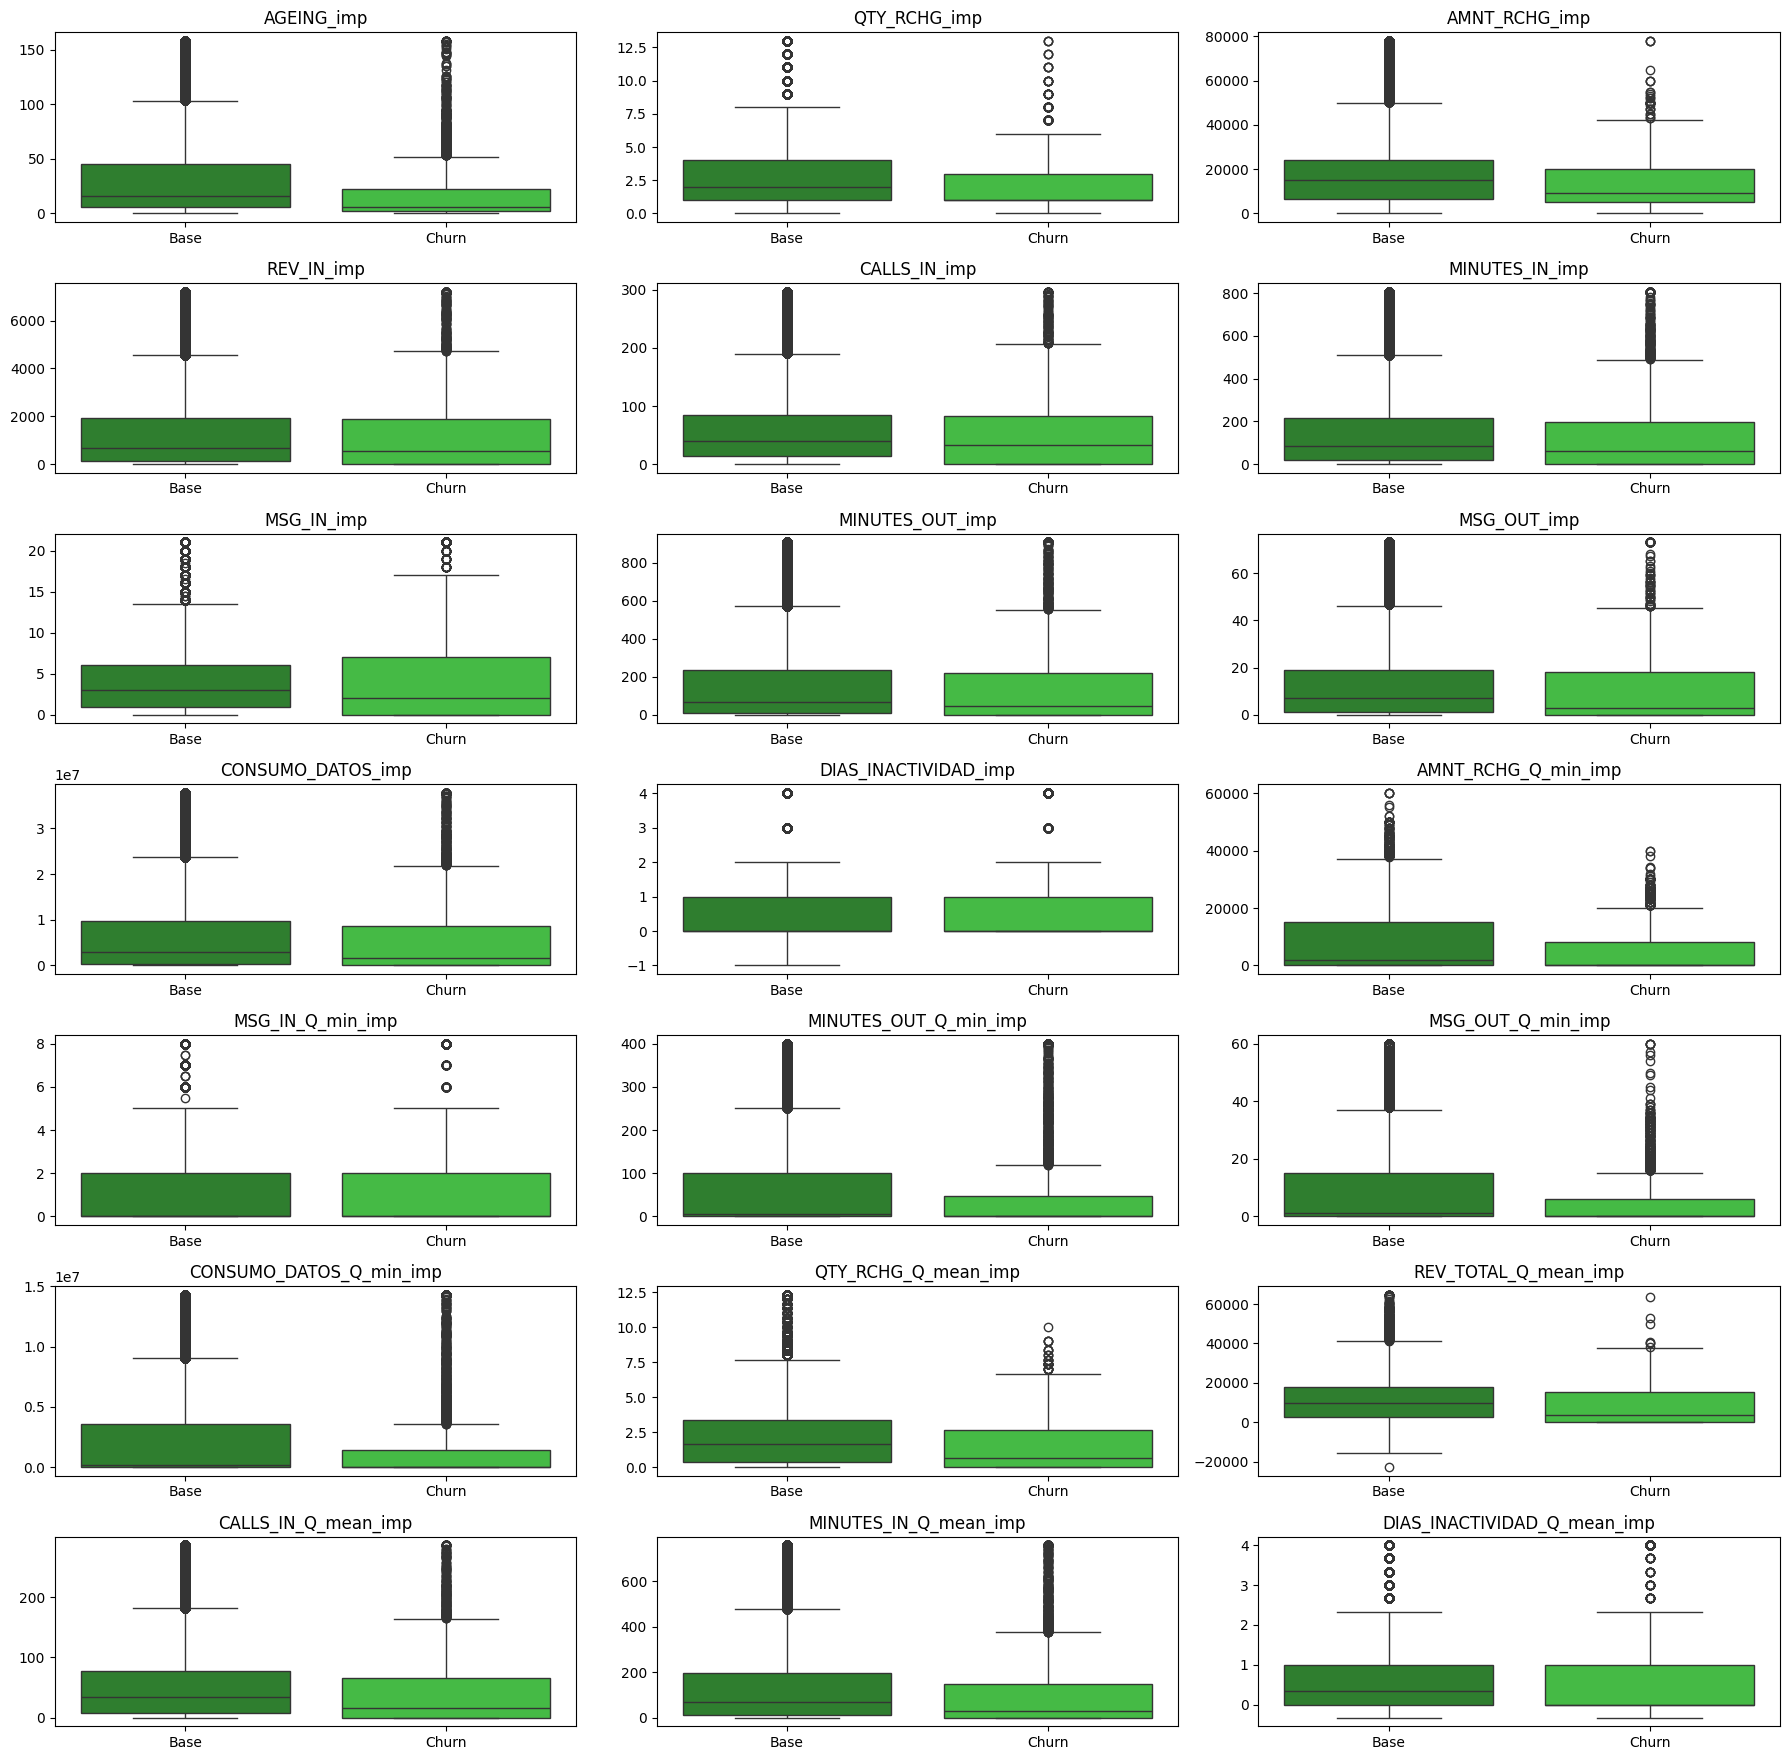

In [47]:
# genero el diagrama de bigotes para evaluar el impacto del recorte de valore extremos sobre las variables numéricas del conjunto de datos
%matplotlib inline

num_vars = len(columns_imp)  # Número de variables

# Configurar la figura y ejes
fig, axes = plt.subplots(12, 3, figsize=(18, 30))  # Grilla de 6x3
palette_no = {'Base': 'forestgreen', 'Churn': 'limegreen'}

# Generar gráficos en cada celda
for i, ax in enumerate(axes.flat[:num_vars]):
    sns.boxplot(x=dfat['TIPO']
                , y=dfat[columns_imp[i]]
                , data=dfat
                , hue=dfat['TIPO']
                , palette=palette_no
                , legend=False
                , ax = ax
               )
    ax.set_title(columns_imp[i])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Ocultar las celdas vacías
for j in range(num_vars, len(axes.flat)):
    axes.flat[j].set_visible(False)

# Ajustar el diseño
plt.tight_layout()
plt.show()

## Segmentación

### PCA

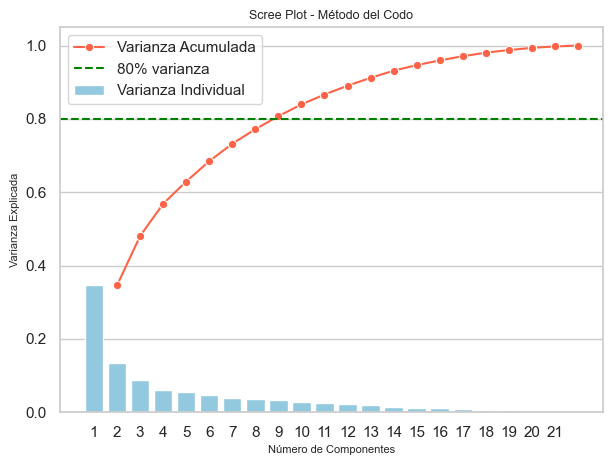

In [48]:
# Seccion para aplicar un análisis PCA y sobre este un ejercicio de Klustering con K-means
from sklearn.decomposition import PCA

# Escalar los datos (PCA requiere variables estandarizadas)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dfat[columns_imp])

# Aplicar PCA sin reducir dimensiones (para análisis)
pca = PCA(n_components=None)
pca.fit(df_scaled)

# Obtener varianza explicada
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

#print(' % de varianza explicada', explained_var, '\n')
#print(' % de varianza explicada', cumulative_var, '\n')
# Crear DataFrame para el gráfico
df_variance = pd.DataFrame({
    'Componente': range(1, len(explained_var) + 1),
    'Varianza Individual': explained_var,
    'Varianza Acumulada': cumulative_var
})

# Gráfico con Seaborn (método del codo)
plt.figure(figsize=(7, 5))
sns.set_theme(style="whitegrid")

# Gráfico de barras (varianza individual)
sns.barplot(
    x='Componente', 
    y='Varianza Individual', 
    data=df_variance,
    color='skyblue',
    label='Varianza Individual'
)

# Línea de varianza acumulada
sns.lineplot(
    x='Componente', 
    y='Varianza Acumulada', 
    data=df_variance,
    marker='o',
    color='tomato',
    label='Varianza Acumulada'
)

# Añadir etiquetas
plt.axhline(y=0.80, color='green', linestyle='--', label='80% varianza')  # Umbral común
plt.title('Scree Plot - Método del Codo', fontsize = 9)
plt.xlabel('Número de Componentes', fontsize = 8)
plt.ylabel('Varianza Explicada', fontsize = 8)
plt.legend()
plt.show()

In [49]:
# de acuerdo con el gráfico anterior, con 9 componentes se explica el 80% de la varianza del modelo
# Número de componentes seleccionados

nro_c = 9

pca_final = PCA(n_components=nro_c)
pca_result = pca_final.fit_transform(df_scaled)
df_pca = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(nro_c)])

# Verificar varianza acumulada
cumulative_var = np.cumsum(pca_final.explained_variance_ratio_)
print(f"Varianza acumulada con {nro_c} componentes: {cumulative_var[-1]:.2%}")

Varianza acumulada con 9 componentes: 83.93%


### K-means

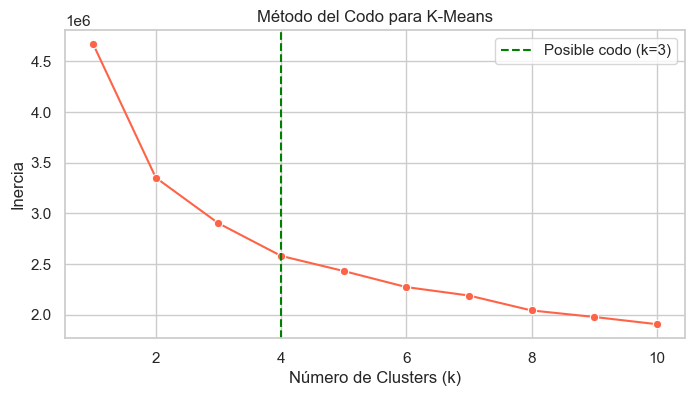

In [50]:
# K-means con metodo del codo

from sklearn.cluster import KMeans

# Calcular inercia para diferentes números de clusters
inertias = []
k_values = range(1, 11)  # Probamos de 1 a 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(df_pca)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid")
sns.lineplot(x=k_values, y=inertias, marker='o', color='tomato')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.axvline(x=4, color='green', linestyle='--', label='Posible codo (k=3)')  # Ajusta según tu gráfico
plt.legend()
plt.show()

In [51]:
# De acuerdo con el metodo del codo, elegimos k=4 

k_final = 4
kmeans_final = KMeans(n_clusters=k_final, n_init='auto', random_state=42)
clusters = kmeans_final.fit_predict(df_pca)

# Añadir etiquetas al DataFrame
df_pca['Cluster'] = clusters

In [52]:
# Valido el impacto de la clusterizacion con el churn

try:
    dfat = dfat.drop('Cluster', axis=1)
except:
    print('aun no se ha creado la variable Cluster')
    
    
dfat = pd.concat([dfat, df_pca['Cluster']], axis=1)

contingency_table_km = pd.crosstab(dfat['Cluster'], dfat['TIPO'])
contingency_table_km

aun no se ha creado la variable Cluster


TIPO,Base,Churn
Cluster,,
0,62581,497
1,75113,1373
2,36779,410
3,87356,900


In [53]:
# en esta seccion unifico las variables numericas procesadas con las variables numéricas

columns_obt = dfat.select_dtypes(include=['object']).columns
columns_obt = columns_obt.tolist()
colt_imp = ['ID'] + columns_obt + columns_imp + ['Cluster']

# la variable 'GROSS' indica Si el usuario es nuevo en la base
# en los siguientes análisis N tiene mucha relevancia en el resultado 
# por este motivo la retiro para evaluar su impacto en los resultados
columns_obt.remove('GROSS')

dfat[colt_imp].shape

(265009, 31)

In [54]:
# variables para aplicar ONE Hot Encoding
#columns_obt

from sklearn.preprocessing import OneHotEncoder

# Seleccionar variables categóricas
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_data = encoder.fit_transform(dfat[columns_obt])

# Crear DataFrame con las nuevas columnas
dfat_encoded = pd.DataFrame(encoded_data
                               ,columns=encoder.get_feature_names_out(columns_obt)
                               )

dfat_encoded = dfat_encoded.drop(['TIPO_Base','TIPO_Churn'], axis = 1)

In [55]:
# Presento los nombres de las columnas transformadas con One-Hot Encodig
dfat_encoded.columns

Index(['ACTIVATION_CHANNEL_DISTRIBUIDORES', 'ACTIVATION_CHANNEL_OTHERS',
       'TECHNOLOGY_2G', 'TECHNOLOGY_3G Y 4G', 'DATA_USR_N', 'DATA_USR_Y',
       'DEVICE_TYPE_LOW END AND OTHER MOB DEV', 'DEVICE_TYPE_SMARTPHONE',
       'REGIONAL_ANDINA', 'REGIONAL_BOGOTA', 'REGIONAL_COSTA', 'REGIONAL_SUR',
       'REGIONAL_TBD', 'DATA_USR_Q_N', 'DATA_USR_Q_Y'],
      dtype='object')

In [56]:
# Combino con columnas numéricas
dftm = pd.concat([dfat[columns_imp], dfat_encoded], axis=1)
dftm = pd.concat([dfat['ID'], dftm, dfat['Cluster'],dfat['TIPO']], axis=1)

In [57]:
# bk de control
dftm.to_csv('dftm.csv', sep = '|', index = False, encoding = 'ansi', decimal = '.')


# Código para restaurar el df
#dftm = pd.read_csv('dftm.csv', sep = '|', encoding = 'ansi', decimal = '.')
#dftm.head()

In [58]:
# Presento la distribución de registros por cluster y por Tipo de Churn

print(dftm['Cluster'].value_counts())
conting_tbl_clust = pd.crosstab(dftm['Cluster'], dftm['TIPO'])
print(conting_tbl_clust)

print('shape',dftm.shape,'\n')
dftm['TIPO'].value_counts()

Cluster
3    88256
1    76486
0    63078
2    37189
Name: count, dtype: int64
TIPO      Base  Churn
Cluster              
0        62581    497
1        75113   1373
2        36779    410
3        87356    900
shape (265009, 39) 



TIPO
Base     261829
Churn      3180
Name: count, dtype: int64

### Selección registros para entrenar y testear el modelo

In [59]:
dftm.reset_index(inplace = True, drop = True)

# Seleccion del 90% de registros del dataframe
dftm_s = dftm.groupby('TIPO').sample(frac=0.9, random_state=42)
# Seleccion del 20% de registros para posterior validacion
dftm_v = dftm.drop(dftm_s.index)

In [60]:
# regeneramos los indices
dftm_s.reset_index(inplace = True, drop = True)
dftm_v.reset_index(inplace = True, drop = True)

In [61]:
# según la curva de aprendizaje en *80,000 registros el modelo ya no aprende más, 
# por este motivo voy a seleccionar una muestra mas pequeña de datos, es decir el 30%

dftm_s = dftm.groupby('TIPO').sample(frac=0.3, random_state=42)
dftm_sb = dftm_s[dftm_s['TIPO']=='Base']
dftm_c = dftm[dftm['TIPO']=='Churn']
dftm_s = pd.concat([dftm_sb,dftm_c], axis=0)
dftm_s = dftm_s.sample(frac=1, random_state=42).reset_index(drop=True)

dftm_s.shape

(81729, 39)

In [62]:
# presento las validaciones
print('\nSample Shape: \n', dftm_s.shape)
print('\nSample Tipo: \n', dftm_s['TIPO'].value_counts())
print('\nSample Cluster: \n', dftm_s['Cluster'].value_counts())
conting_tbl_clust_s = pd.crosstab(dftm_s['Cluster'], dftm_s['TIPO'])
print('\nValidation Shape: \n', dftm_v.shape)
print('\nContingency Table Sample',conting_tbl_clust_s)
print('\nValidation Tipo: \n', dftm_v['TIPO'].value_counts())
print('\nValidation Cluster: \n', dftm_v['Cluster'].value_counts())
conting_tbl_clust_v = pd.crosstab(dftm_v['Cluster'], dftm_v['TIPO'])
print('\nContingency Table Validation',conting_tbl_clust_v)


Sample Shape: 
 (81729, 39)

Sample Tipo: 
 TIPO
Base     78549
Churn     3180
Name: count, dtype: int64

Sample Cluster: 
 Cluster
3    27263
1    23889
0    19194
2    11383
Name: count, dtype: int64

Validation Shape: 
 (26501, 39)

Contingency Table Sample TIPO      Base  Churn
Cluster              
0        18697    497
1        22516   1373
2        10973    410
3        26363    900

Validation Tipo: 
 TIPO
Base     26183
Churn      318
Name: count, dtype: int64

Validation Cluster: 
 Cluster
3    8744
1    7616
0    6384
2    3757
Name: count, dtype: int64

Contingency Table Validation TIPO     Base  Churn
Cluster             
0        6336     48
1        7475    141
2        3712     45
3        8660     84


## Modelos

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

### Creación de sets de entrenamiento y prueba

In [64]:
# Creo los sets de datos para el modelo
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dftm_sm = dftm_s
cols_mod = dftm_sm.columns
cols_mod = cols_mod.tolist()
cols_mod.remove('ID')
cols_mod.remove('TIPO')

X = dftm_s[cols_mod].values
y = dftm_s['TIPO'].values
y = le.fit_transform(y)

X_val = dftm_v[cols_mod].values
y_val = dftm_v['TIPO'].values
y_val = le.fit_transform(y_val)

In [65]:
unique_y, counts_y = np.unique(y, return_counts=True)
print('distribucion y', dict(zip(unique_y, counts_y)))

unique_yv, counts_yv = np.unique(y_val, return_counts=True)
print('distribucion yv', dict(zip(unique_yv, counts_yv)))

distribucion y {0: 78549, 1: 3180}
distribucion yv {0: 26183, 1: 318}


In [66]:
# Creo set de entreamiento y prueba con una proporción 80% - 20%

X_m = X # X 
y_m = y # y

X_train, X_test, y_train, y_test = train_test_split(X_m
                                                    ,y_m
                                                    ,test_size = 0.2
                                                    ,stratify = y_m
                                                    ,random_state=1
                                                    ,shuffle=True
                                                    )

In [67]:
#y_train, y_test
unique_yt, counts_yt = np.unique(y_train, return_counts=True)
print('distribucion y_train',dict(zip(unique_yt, counts_yt)))

distribucion y_train {0: 62839, 1: 2544}


### Entrenamiento Regresion Logistica

In [68]:
from sklearn.model_selection import GridSearchCV

# Definir SMOTE
smote = SMOTE(sampling_strategy=0.50, random_state=42)  # Balancear al 50% de la mayoría
# Aplicar SMOTE antes de usar el pipeline
X_res, y_res = smote.fit_resample(X, y)

unique_y_res, counts_y_res = np.unique(y_res, return_counts=True)
print('distribucion y resampled SMOTE' , dict(zip(unique_y_res, counts_y_res)),'\n')

#class_weight='balanced',
weight_ratio = 100    # Peso 100x para la clase 1 (experimenta con esto)
pipe_lr = make_pipeline(StandardScaler(),
                        #PCA(n_components = 9),
                        LogisticRegression(solver='liblinear', # 'newton-cholesky', 
                                           #class_weight={0: 1, 1: weight_ratio},  # Ajuste automático de pesos
                                           #penalty='l2',             # Regularización L2 (evitar overfitting)
                                           #C=0.1,                    # Fuerza de regularización (menor C = más regularización)
                                           max_iter=10000,
                                           tol=1e-3,
                                           random_state=42                                           
                                          )
                       )


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {
    'logisticregression__C': [0.1, 1.0, 10.0],  # Más opciones
    'logisticregression__penalty': ['l1', 'l2'],          # Probar L1 y L2
    'logisticregression__class_weight': [None, {0: 1, 1: 50}, {0: 1, 1: 100}, {0: 1, 1: 200}]
    #'smote__sampling_strategy': [0.25, 0.5]  # Ajustar SMOTE
}

gs = GridSearchCV(estimator=pipe_lr
                  ,param_grid=param_grid
                  ,scoring='recall'
                  ,cv=cv
                  ,n_jobs=-1)

gs.fit(X_res, y_res)

print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

distribucion y resampled SMOTE {0: 78549, 1: 39274} 

1.0
{'logisticregression__C': 0.1, 'logisticregression__class_weight': {0: 1, 1: 200}, 'logisticregression__penalty': 'l1'}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight={0: 1, 1: 200},
                                    max_iter=10000, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=0.001))])


In [69]:
# obtengo las caracteristicas de este modelo
best_model = gs.best_estimator_
logistic_model = best_model.named_steps['logisticregression']
coeficientes = logistic_model.coef_[0]
coeficientes

array([-0.27895695,  0.31579243, -0.61248558,  0.21993657, -0.01166287,
       -0.14813038,  0.23838259,  0.07534311,  0.53057058,  0.16633366,
       -0.57824324, -0.04358531,  0.06236295, -0.02931779, -0.50303565,
       -0.12726456, -0.23868672,  0.14463477,  0.33706793, -0.16210536,
       -0.12463073, -0.1147836 , -0.20985026,  0.03513014, -0.6613634 ,
       -0.42139699, -0.21325969,  0.00327451,  0.13011422, -0.01311362,
        0.10522114,  0.07259241, -0.0328411 ,  0.        ,  0.24046145,
       -0.18814906, -0.08385536])

#### Predicciones Logistic Regression

In [70]:
# 4. Predecir probabilidades calibradas en validación
y_pred = gs.predict(X_test)
y_proba = gs.predict_proba(X_test)[:, 1]  # Probabilidades clase 1


Umbral óptimo para recall ≥ 80.0%: 42.867%


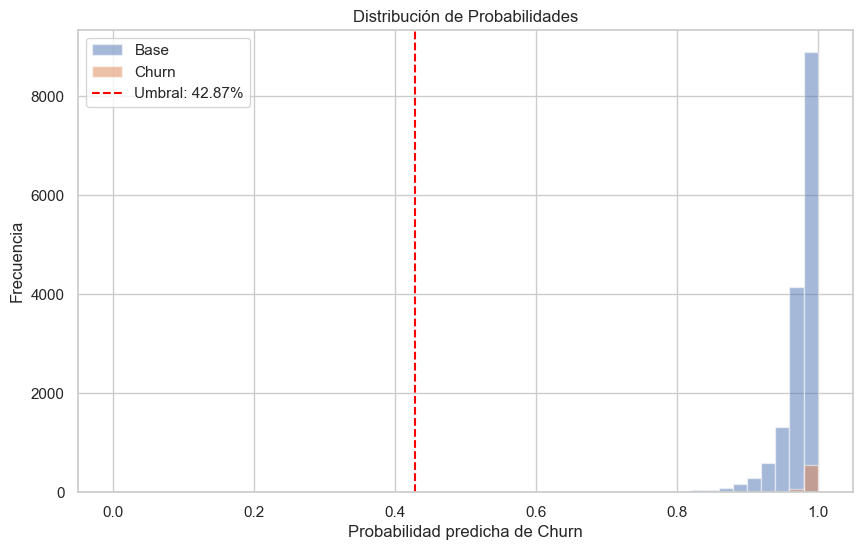

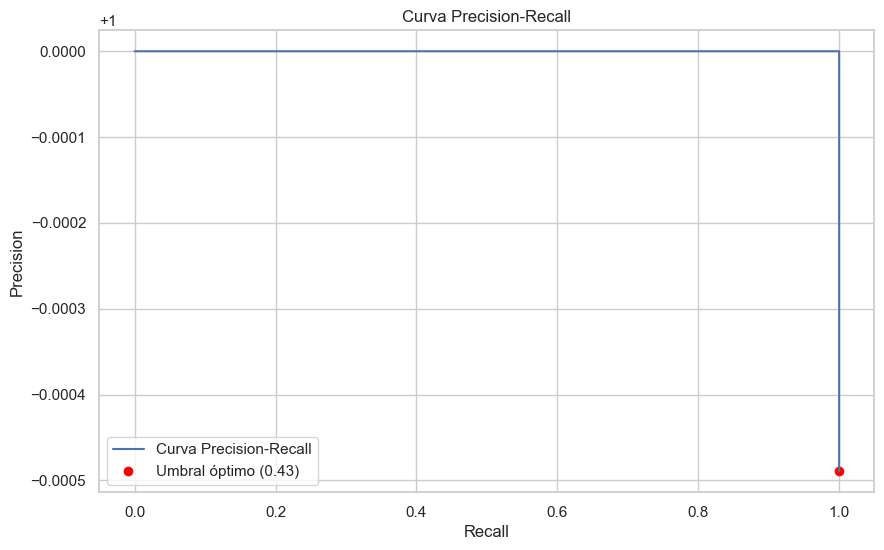

In [71]:
import matplotlib.pyplot as plt

# Optimizar el umbral
precision, recall, thresholds = precision_recall_curve(y_pred, y_proba)

# Definir recall mínimo deseado (ej: 80%)
target_recall = 0.80

# Encontrar el umbral más bajo que cumple con el recall objetivo
optimal_threshold = thresholds[np.argmax(recall >= target_recall)]
print(f"Umbral óptimo para recall ≥ {target_recall*100}%: {optimal_threshold*100:.3f}%")

# En lugar de model.predict(X_test), usar:
y_pred_adj = (y_proba >= optimal_threshold).astype(int)


plt.figure(figsize=(10, 6))
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.5, label='Base', range=(0, 1))
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.5, label='Churn', range=(0, 1))
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Umbral: {optimal_threshold*100:.2f}%')
plt.xlabel('Probabilidad predicha de Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades')
plt.legend()
plt.show()


# Curva precision - recall

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Curva Precision-Recall')
plt.scatter(recall[np.argmax(recall >= target_recall)], 
            precision[np.argmax(recall >= target_recall)], 
            color='red', label=f'Umbral óptimo ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

#### Matriz de Confusion RL

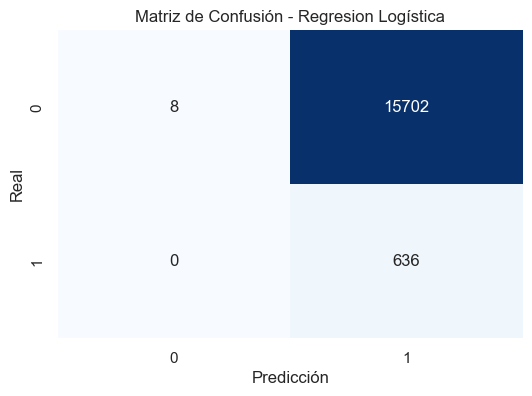

In [72]:
# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresion Logística")
plt.show()

In [73]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' %    recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' %        f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.039
Recall: 1.000
F1: 0.075


{0: 97, 1: 16249}


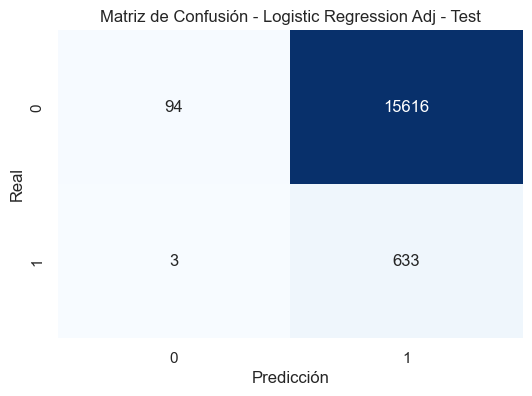

In [74]:
# Hacemos ejercicios con el umbral para ajustar el comportamiento del modelo Logistic Regression

# Obtener probabilidades predictivas
y_pred_lr_t = gs.predict(X_test)
y_proba_lr_t = gs.predict_proba(X_test)[:, 1]

threshold = 0.80  # Ajusta el umbral según tu análisis

y_pred_lr_t_adj = (y_proba_lr_t >= threshold).astype(int)  # Convierte probabilidades en 0 o 1

unique_lr_adj, counts_lr_adj = np.unique(y_pred_lr_t_adj, return_counts=True)
print(dict(zip(unique_lr_adj, counts_lr_adj)))


# Matriz de confusión LR
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr_t_adj), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Logistic Regression Adj - Test")
plt.show()




#### Curva lift Logistic Regression

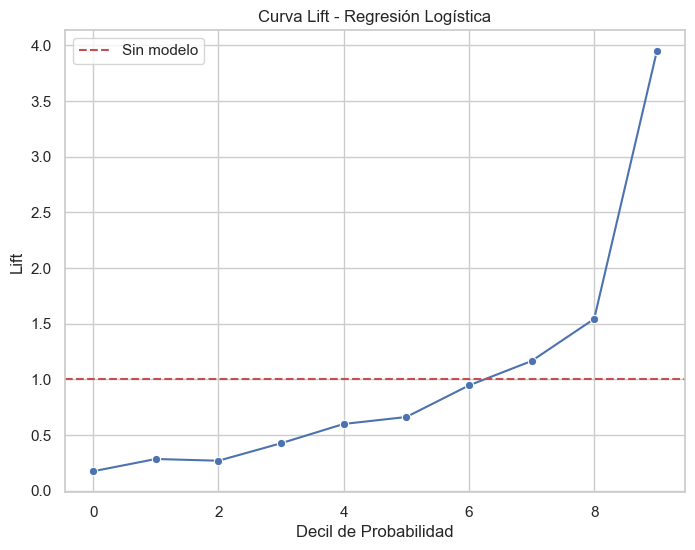

In [75]:
# Obtener probabilidades predictivas
y_prob = gs.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva (1)

# Crear un DataFrame para calcular los deciles
df_lift = pd.DataFrame({'probabilidad': y_prob, 'real': y_test})
df_lift['decile'] = pd.qcut(df_lift['probabilidad'], q=10, labels=False)  # Divide en 10 grupos

# Calcular lift por decil
lift_table = df_lift.groupby('decile')['real'].mean().reset_index()
lift_table['lift'] = lift_table['real'] / lift_table['real'].mean()  # Comparación con promedio total

# Graficar la curva Lift
plt.figure(figsize=(8, 6))
sns.lineplot(data=lift_table, x='decile', y='lift', marker='o', linestyle='-')
plt.axhline(y=1, color='r', linestyle='--', label='Sin modelo')
plt.xlabel('Decil de Probabilidad')
plt.ylabel('Lift')
plt.title('Curva Lift - Regresión Logística')
plt.legend()
plt.show()


### Entrenamiento XGBoost

In [76]:
# Entrenamiento de XGBoost

import numpy as np
import pandas as pd
#from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
#from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Definir SMOTE para balancear datos
smote = SMOTE(sampling_strategy=0.50, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f"Distribución después de SMOTE: {dict(zip(*np.unique(y_res, return_counts=True)))}\n")

# Definir el modelo XGBoost
xgb_model = XGBClassifier(objective='binary:logistic', 
                          eval_metric='aucpr', #'logloss', #'aucpr'
                          n_estimators=100, 
                          learning_rate=0.1, 
                          max_depth=3, 
                          random_state=42)

# Crear pipeline con XGBoost
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb_model)  # Agregar el modelo al pipeline
])

# Definir validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir hiperparámetros para búsqueda
param_grid_xgb = {
    'xgb__n_estimators': [100] # [100, 200, 300],  
    ,'xgb__learning_rate': [0.1] #[0.01, 0.1, 0.2],  
    ,'xgb__max_depth': [5] # [3, 5, 7],  
    ,'xgb__scale_pos_weight': [25]  # Ajustar peso de clases desbalanceadas
}

# Realizar búsqueda de hiperparámetros con GridSearchCV
gs_xgb = GridSearchCV(pipe_xgb, param_grid=param_grid_xgb, scoring='recall', cv=cv, n_jobs=-1)
gs_xgb.fit(X_res, y_res)

# Modelo calibrado
#calibrated_model_xgb = CalibratedClassifierCV(gs_xgb, method='isotonic', cv=cv)
#calibrated_model_xgb.fit(X_train, y_train)

# Predicciones y probabilidades
y_pred_xgb = gs_xgb.predict(X_test)
y_proba_xgb = gs_xgb.predict_proba(X_test)[:, 1]


# Mostrar los mejores hiperparámetros encontrados
print(f"Mejor puntaje: {gs_xgb.best_score_}")
print(f"Mejores parámetros: {gs_xgb.best_params_}")
print(f"Mejor modelo: {gs_xgb.best_estimator_}")


Distribución después de SMOTE: {0: 78549, 1: 39274}

Mejor puntaje: 0.9866323841034591
Mejores parámetros: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__scale_pos_weight': 25}
Mejor modelo: Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
         

#### Guardar Modelo XGB

In [77]:
"""#gs_xgb

import pickle

# Guardar el modelo entrenado en un archivo
with open('gs_xgb.pkl', 'wb') as file:
    pickle.dump(gs_xgb.best_estimator_, file)"""


"#gs_xgb\n\nimport pickle\n\n# Guardar el modelo entrenado en un archivo\nwith open('gs_xgb.pkl', 'wb') as file:\n    pickle.dump(gs_xgb.best_estimator_, file)"

#### Restaurar Modelo XGB

In [78]:
import pickle

# Cargar el modelo desde el archivo
with open('gs_xgb.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Verificar que el modelo cargado funciona
y_pred_test = loaded_model.predict(X_test)
print(y_pred_test[:5])  # Mostrar algunas predicciones

gs_xgb = loaded_model

[1 0 0 0 0]


#### Predicciones XGB

In [79]:
# Predicciones y probabilidades 
y_pred_xgb = gs_xgb.predict(X_test)
y_proba_xgb = gs_xgb.predict_proba(X_test)[:, 1] # Probabilidad de la clase positiva (1)

#### Curvas de aprendizaje XGB

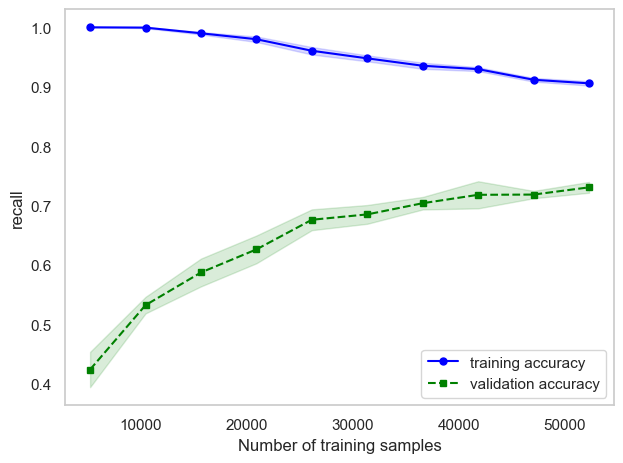

In [80]:
# learning_curve

%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=gs_xgb,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=cv,
                               scoring = 'recall',
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean ,color='blue', marker='o',markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('recall')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

Umbral óptimo para recall ≥ 80.0%: 0.266%


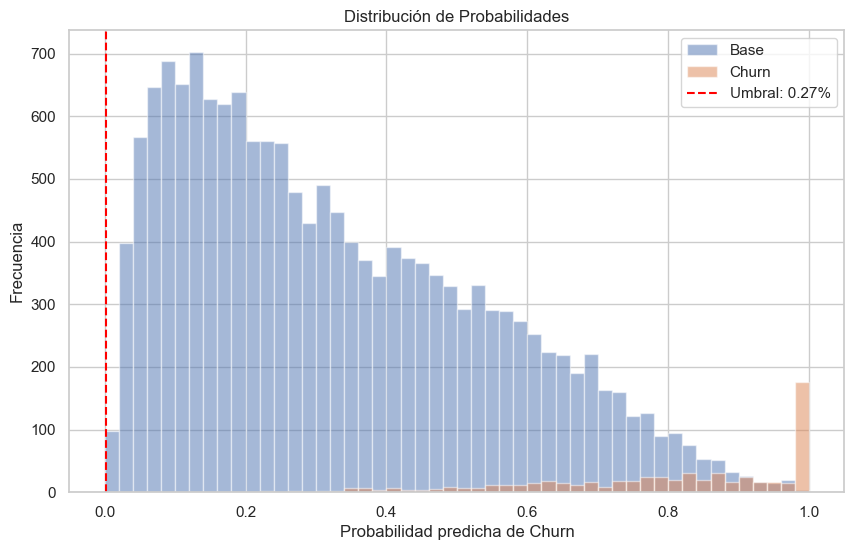

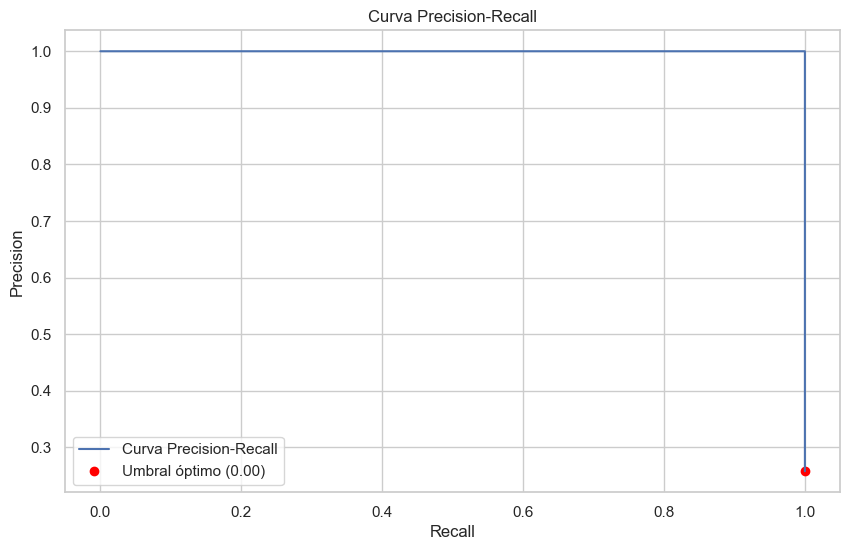

In [81]:
# Curva precision - recall
import matplotlib.pyplot as plt


# Optimizar el umbral
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_pred_xgb, y_proba_xgb)

# Definir recall mínimo deseado (ej: 80%)
target_recall = 0.80

# Encontrar el umbral más bajo que cumple con el recall objetivo
optimal_threshold = thresholds[np.argmax(recall >= target_recall)]
print(f"Umbral óptimo para recall ≥ {target_recall*100}%: {optimal_threshold*100:.3f}%")

# En lugar de model.predict(X_test), usar:
y_pred_adj_xgbu = (y_proba_xgb >= optimal_threshold).astype(int)
#dict(zip(*np.unique(y_pred_adj_xgbu, return_counts=True)))



plt.figure(figsize=(10, 6))
plt.hist(y_proba_xgb[y_test == 0], bins=50, alpha=0.5, label='Base', range=(0, 1))
plt.hist(y_proba_xgb[y_test == 1], bins=50, alpha=0.5, label='Churn', range=(0, 1))
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Umbral: {optimal_threshold*100:.2f}%')
plt.xlabel('Probabilidad predicha de Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Curva Precision-Recall')
plt.scatter(recall[np.argmax(recall >= target_recall)], 
            precision[np.argmax(recall >= target_recall)], 
            color='red', label=f'Umbral óptimo ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
dict(zip(*np.unique(y_test, return_counts=True)))

{0: 15710, 1: 636}

#### Matriz de confusión XGB - Test

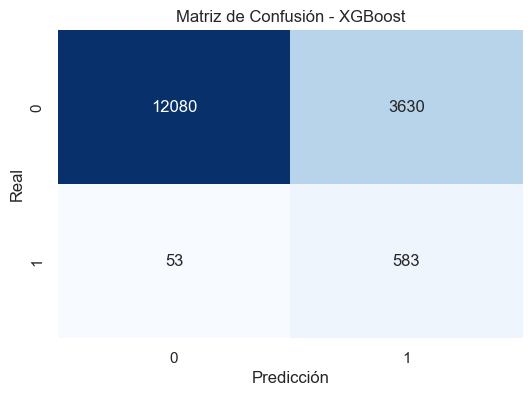

In [83]:
# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

In [84]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred_xgb))
print('Recall: %.3f' %    recall_score(y_true=y_test, y_pred=y_pred_xgb))
print('F1: %.3f' %        f1_score(y_true=y_test, y_pred=y_pred_xgb))

Precision: 0.138
Recall: 0.917
F1: 0.240


#### Importancia de Variables XGB

(37, 2)


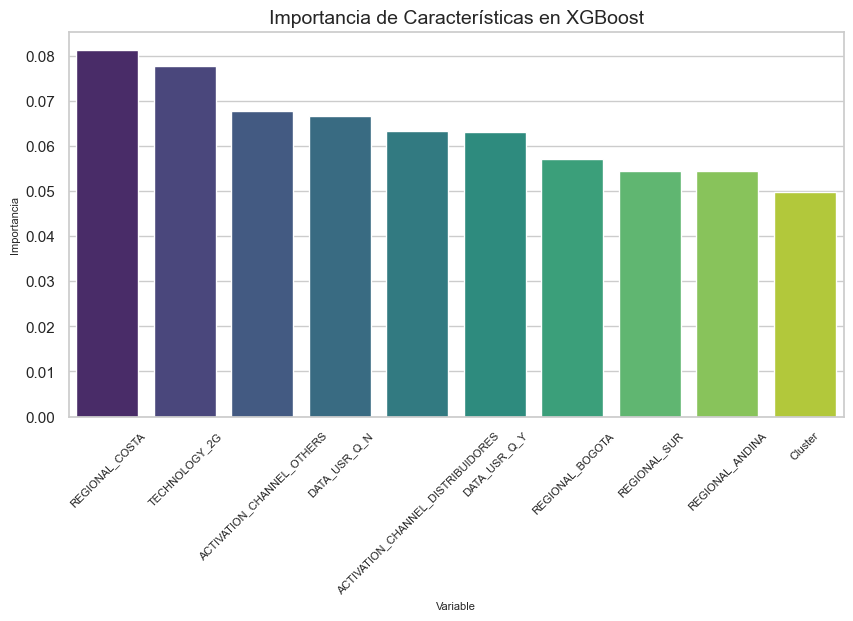

In [85]:
# Graficar con etiquetas más grandes y ordenadas
# Obtener el mejor modelo encontrado por GridSearchCV
try:
    best_xgb = gs_xgb.best_estimator_.named_steps['xgb']
except:
    best_xgb = gs_xgb.named_steps['xgb']    

# Obtener la importancia de características
feature_importance = best_xgb.feature_importances_

column_names = dftm[cols_mod].columns.tolist()
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': feature_importance})
feature_importance = feature_importance.sort_values('Importance', ascending = False)
feature_importance.reset_index(inplace = True, drop = True)
feature_importance.head()

print(feature_importance.shape)
feature_importance.head()

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance[:10]
            , x='Feature'
            , y='Importance'
            , palette='viridis'
            , hue='Feature'
            , legend=False
           )

# Ajustar tamaño de las etiquetas de las categorías en el eje X
plt.xticks(rotation=45, fontsize=8)  # Cambia el tamaño a 14 (ajústalo según lo necesites)

plt.xlabel("Variable", fontsize=8)
plt.ylabel("Importancia", fontsize=8)
plt.title("Importancia de Características en XGBoost", fontsize=14)

plt.show()

#### Curva lift XGBoost

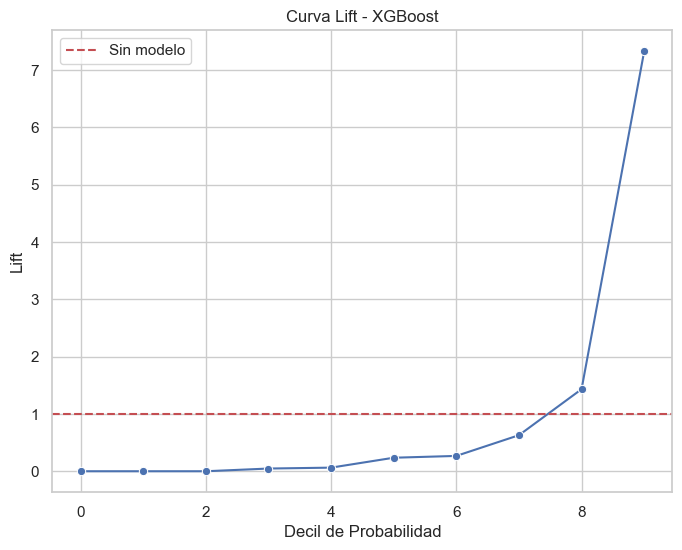

In [86]:

# Crear un DataFrame para calcular los deciles
df_lift = pd.DataFrame({'probabilidad': y_proba_xgb, 'real': y_test})
df_lift['decile'] = pd.qcut(df_lift['probabilidad'], q=10, labels=False)  # Divide en 10 grupos

# Calcular lift por decil
lift_table = df_lift.groupby('decile')['real'].mean().reset_index()
lift_table['lift'] = lift_table['real'] / lift_table['real'].mean()  # Comparación con promedio total

# Graficar la curva Lift
plt.figure(figsize=(8, 6))
sns.lineplot(data=lift_table, x='decile', y='lift', marker='o', linestyle='-')
plt.axhline(y=1, color='r', linestyle='--', label='Sin modelo')
plt.xlabel('Decil de Probabilidad')
plt.ylabel('Lift')
plt.title('Curva Lift - XGBoost')
plt.legend()
plt.show()


#### Curva ROC

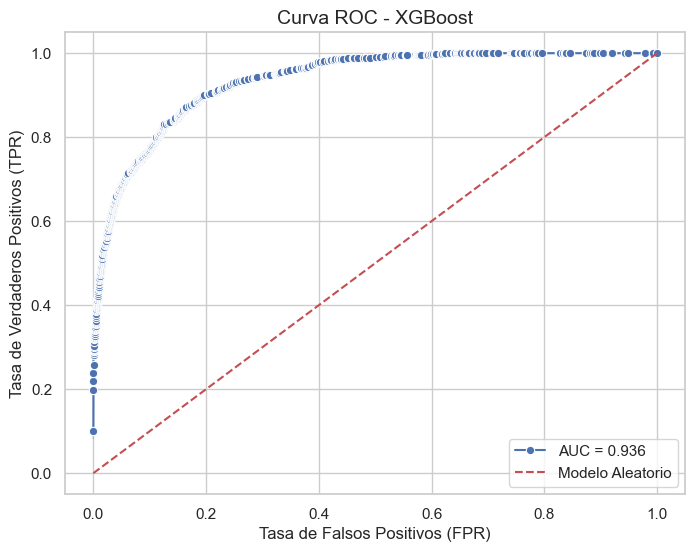

In [87]:
from sklearn.metrics import roc_curve, auc

# Obtener valores para la curva ROC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)  # Área bajo la curva

# Graficar la curva ROC con Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr_xgb, y=tpr_xgb, marker='o', markersize = 6, linestyle='-', label=f'AUC = {roc_auc_xgb:.3f}')
plt.plot([0, 1], [0, 1], 'r--', label="Modelo Aleatorio")
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC - XGBoost', fontsize=14)
plt.legend()
plt.show()

#### Validación con Set de Validacion - 10 %

{0: 20112, 1: 6389}


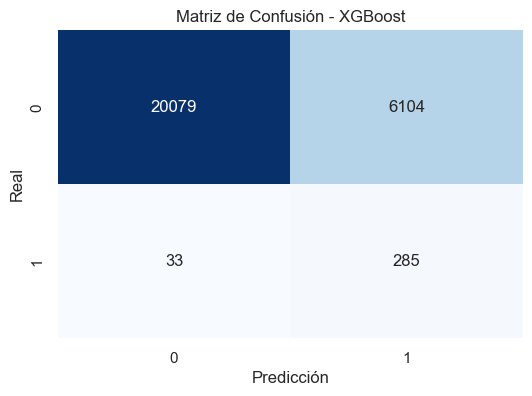

In [88]:
# Hacemos ejercicios con el umbral para ajustar el comportamiento del modelo XGBoost

# Obtener probabilidades predictivas
y_pred_xgb_v = gs_xgb.predict(X_val)
y_proba_xgb_v = gs_xgb.predict_proba(X_val)[:, 1]

threshold = 0.50  # Ajusta el umbral según tu análisis

y_pred_xgb_v_adj = (y_proba_xgb_v >= threshold).astype(int)  # Convierte probabilidades en 0 o 1

unique_g_adj, counts_g_adj = np.unique(y_pred_xgb_v_adj, return_counts=True)
print(dict(zip(unique_g_adj, counts_g_adj)))


# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_xgb_v_adj), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

In [89]:
print('Precision: %.3f' % precision_score(y_true=y_val, y_pred=y_pred_xgb_v))
print('Recall: %.3f' %    recall_score(y_true=y_val, y_pred=y_pred_xgb_v))
print('F1: %.3f' %        f1_score(y_true=y_val, y_pred=y_pred_xgb_v))

Precision: 0.045
Recall: 0.896
F1: 0.085


## Descripción de las variables

| VARIABLE                | DESCRIPCIÓN                                         |
|-------------------------|-----------------------------------------------------|
| TIPO                    | Si es churn                                         |
| RAZON                   | Si fue una portación                                |
| ACTIVATION_CHANNEL      | Canal de activación del usuario                     |
| AGEING                  | Antigüedad del usuario                              |
| BUSINESS_UNIT           | Unidad de negocio                                   |
| TECHNOLOGY              | Tecnología de navegación                           |
| DEVICE_TECHNOLOGY       | Tecnología de navegación del dispositivo del usuario |
| DATA_USR                | Sí paga por los datos que consume                   |
| DEVICE_TYPE             | Tipo de dispositivo del usuario                     |
| REGIONAL                | Área geográfica donde trafica el usuario            |
| DEPARTMENT              | Departamento donde trafica el usuario               |
| CITY                    | Ciudad donde trafica el usuario                     |
| OPENING                 | Si el usuario empezó activo el mes                  |
| GROSS                   | Si el usuario es nuevo en la base                   |
| RECONNECTION            | Si el usuario se reconectó en el último mes         |
| QTY_RCHG                | Cantidad de recargas que realiza el usuario         |
| AMNT_RCHG               | Monto de recarga                                    |
| REV_TOTAL               | Ingreso total generado por el usuario               |
| REV_IN                  | Ingreso entrante generado por el usuario            |
| REV_OUT                 | Ingreso saliente generado por el usuario            |
| ARPU                    | Ingreso promedio por usuario (Average Revenue Per User) |
| CALLS_IN                | Cantidad de llamadas entrantes                      |
| MINUTES_IN              | Minutos en llamadas entrantes                       |
| MSG_IN                  | Mensajes de texto entrantes                         |
| CALLS_OUT               | Cantidad de llamadas salientes                      |
| MINUTES_OUT             | Minutos en llamadas salientes                       |
| MSG_OUT                 | Mensajes de texto salientes                         |
| PCKG_VOICE_FIXNET       | Paquetes de voz a números fijos                     |
| REV_OUT_COMMUNICATION   | Revenue saliente de comunicaciones                  |
| REV_OUT_ENTERTAIMENT    | Revenue saliente de entretenimiento                 |
| REV_OUT_INFORMATION     | Revenue saliente de información                     |
| REV_OUT_SOLUTIONS       | Revenue saliente de soluciones                      |
| CONSUMO_DATOS           | Cantidad de datos consumidos por el usuario         |
| CORE                    | Sí el usuario consumió 1500 pesos o más             |
| DIAS_INACTIVIDAD        | Cantidad de días en que el usuario no realizó ninguna actividad |
| QTY_PQT                 | Cantidad de paquetes comprados por el usuario en el mes |
| PQT_MAS_COMPRADO        | Paquete más comprado por el usuario                 |


In [90]:
columns_dfini = dftm_s[cols_mod].columns.tolist()

df_X_train = pd.DataFrame(X_train, columns=columns_dfini)  # Opcional: definir nombres de columna
df_y_train = pd.DataFrame(y_train, columns=['TIPO'])

df_X_test = pd.DataFrame(X_test, columns=columns_dfini)  # Opcional: definir nombres de columna
df_y_test = pd.DataFrame(y_test, columns=['TIPO'])

df_X_val = pd.DataFrame(X_val, columns=columns_dfini)  # Opcional: definir nombres de columna
df_y_val = pd.DataFrame(y_val, columns=['TIPO'])

# Asignacion de Prediccion y Probabilidad al DF

In [ ]:
# seccion para recuperar el ID de los df
le = LabelEncoder()

cols_mod_id = dftm_s.columns
cols_mod_id = cols_mod_id.tolist()
cols_mod_id.remove('TIPO')

X_m_id = dftm_s[cols_mod_id].values
y_m_id = dftm_s['TIPO'].values
y_m_id = le.fit_transform(y_m_id)

X_val_id = dftm_v[cols_mod_id].values
y_val_id = dftm_v['TIPO'].values
y_val_id = le.fit_transform(y_val_id)
 
X_train_id, X_test_id, y_train_id, y_test_id = train_test_split(X_m_id
                                                    ,y_m_id
                                                    ,test_size = 0.2
                                                    ,stratify = y_m_id
                                                    ,random_state=1
                                                    ,shuffle=True
                                                    )

columns_dfini_id = dftm_s[cols_mod_id].columns.tolist()

df_X_train_id = pd.DataFrame(X_train_id, columns=columns_dfini_id)  # Opcional: definir nombres de columna
df_y_train_id = pd.DataFrame(y_train_id, columns=['TIPO'])

df_X_test_id = pd.DataFrame(X_test_id, columns=columns_dfini_id)  # Opcional: definir nombres de columna
df_y_test_id = pd.DataFrame(y_test_id, columns=['TIPO'])

df_X_val_id = pd.DataFrame(X_val_id, columns=columns_dfini_id)  # Opcional: definir nombres de columna
df_y_val_id = pd.DataFrame(y_val_id, columns=['TIPO'])

#

df_X_train_id['TIPO'] = df_y_train['TIPO']
df_X_train_id['prediccion_xgb'] = df_y_train['TIPO']
df_X_train_id['prediccion_proba_xgb'] = 1.0

df_X_test_id['TIPO'] = df_y_test['TIPO'] 
df_X_test_id['prediccion_xgb'] = y_pred_xgb
df_X_test_id['prediccion_proba_xgb'] = y_proba_xgb

df_X_val_id['TIPO'] = df_y_val_id['TIPO'] 
df_X_val_id['prediccion_xgb'] = y_pred_xgb_v
df_X_val_id['prediccion_proba_xgb'] = y_proba_xgb_v


df_calif = pd.concat([df_X_train_id, df_X_test_id, df_X_val_id], axis=0)
df_calif = df_calif.sample(frac=1, random_state=42).reset_index(drop=True)
df_calif['ID']= df_calif['ID'].round().astype(np.int64)

# Agrego variable REV_TOTAL del df inicial
df_rt = df[['ID','REV_TOTAL']]
df_calif_rt = df_calif.merge(df_rt, on='ID', how='inner')
df_calif_rt.to_csv('df_calif_rt.csv', sep = '|', index = False, encoding = 'ansi', decimal = '.')


# Código para restaurar el df
#df_calif = pd.read_csv('df_calif.csv', sep = '|', encoding = 'ansi', decimal = '.')
#df_calif.head()

In [97]:
print(dftm_s.shape)
print(df_calif.shape)

(81729, 39)
(108230, 41)


# Ejercicio con el DF completo - Evaluacion Full

(265009, 39)


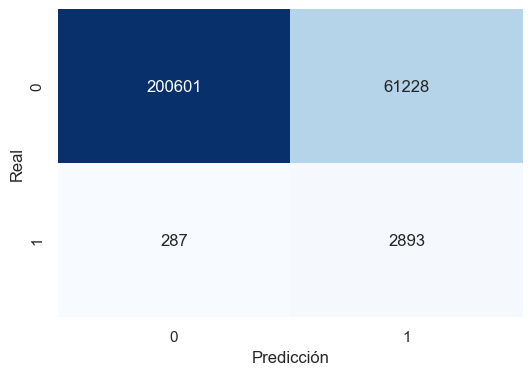

In [ ]:
print(dftm.shape)

X_full = dftm[cols_mod].values
y_full = dftm['TIPO'].values
y_full = le.fit_transform(y_full)

y_pred_xgb_full = gs_xgb.predict(X_full)
y_proba_xgb_full = gs_xgb.predict_proba(X_full)[:, 1] # Probabilidad de la clase positiva (1)


# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_full, y_pred_xgb_full), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
#plt.title("Matriz de Confusión - XGBoost")
plt.show()

In [151]:
print('Precision Full: %.3f' % precision_score(y_true=y_full, y_pred=y_pred_xgb_full))
print('Recall Full: %.3f' %    recall_score(y_true=y_full, y_pred=y_pred_xgb_full))
print('F1 Full: %.3f' %        f1_score(y_true=y_full, y_pred=y_pred_xgb_full))

Precision Full: 0.045
Recall Full: 0.910
F1 Full: 0.086


In [180]:
# en esta seccion hago todos los ajustes para exportar el df total 
# filtrado por CORE 

dftmf = dftm
dftmf['prediccion_xgb'] = y_pred_xgb_full
dftmf['prediccion_proba_xgb'] = y_proba_xgb_full

# Agrego variable REV_TOTAL del df inicial
df_rt = df[['ID','REV_TOTAL','DEVICE_TYPE','REGIONAL','TECHNOLOGY']]

df_calif_f_rt = dftmf.merge(df_rt, on='ID', how='inner')
df_calif_f_rt.to_csv('df_calif_f_rt_v.csv', sep = '|', index = False, encoding = 'ansi', decimal = '.')

# Código para restaurar el df
#df_calif_f_rt = pd.read_csv('df_calif_f_rt_v.csv', sep = '|', encoding = 'ansi', decimal = '.')
#df_calif_f_rt.head()

In [178]:
df_calif_f_rt.shape

(265009, 42)